In [1]:
import numpy as np
import pandas as pd
import glob, os, sys, time
sys.path.append('/Users/shiyunqiu/')
from utils.misc import getConfigFile, readPickle, displayTime, loadHDF5,getLowestError
from   model_th.dmm import DMM
import model_th.learning as DMM_learn
import model_th.evaluate as DMM_evaluate
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
mpl.rcParams['lines.linewidth']=2.5
mpl.rcParams['lines.markersize']=8
mpl.rcParams['text.usetex']=True
mpl.rcParams['text.latex.unicode']=True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['text.latex.preamble']= ['\usepackage{amsfonts}','\usepackage{amsmath}']
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize']=20
mpl.rcParams['legend.fontsize']=20

/Users/shiyunqiu/miniconda3/envs/myenv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('/Users/shiyunqiu/AM231_Project/data/coinbaseUSD.csv')

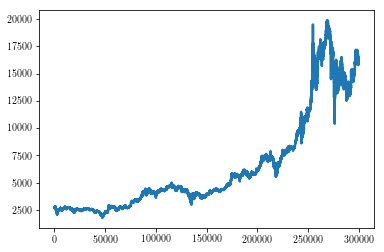

In [3]:
plt.plot(range(len(df.Close[-300000:])), df.Close[-300000:])

In [4]:
df = df.Close[-300000:].reshape(-1,1)
print(df.shape)

(300000, 1)


/Users/shiyunqiu/miniconda3/envs/myenv/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [5]:
# split into train and test sets
train_size = 298000
train_all, test_all = df[:train_size, :], df[train_size:, :]
print(len(train_all), len(test_all))

(298000, 2000)


In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_all)
train_all = scaler.transform(train_all)
test_all = scaler.transform(test_all)

In [9]:
def generate_sample(T, start_indx, end_indx, df):
    sample = []
    idx = range(start_indx, end_indx, 1)
    for val in idx:
        piece = df[val:val+T, :]
        sample.append(piece)
    return np.array(sample), idx

In [11]:
# create dataset to pass into DKF

# size of each set
# train_size = int(len(train_all) * 0.9)
# valid_size = int(len(train_all) * 0.1)

# Train: T=10, 296000 samples
train, train_idx = generate_sample(10, 0, 296000, train_all)

# Valid: T=10, 1989 samples
valid, valid_idx = generate_sample(10, 296000, len(train_all)-11, train_all)

# # Test: T=10, 1989 sample
test, test_idx = generate_sample(10, 0, len(test_all)-11, test_all)

# Test: T=10, 1 sample
# test = np.array([test_all[:10, :]])
# test_idx = [0]


train_dict = {}
train_dict['tensor'] = train
train_dict['mask'] = np.ones((296000, 10))

valid_dict = {}
valid_dict['tensor'] = valid
valid_dict['mask'] = np.ones((1989, 10))

test_dict = {}
test_dict['tensor'] = test
test_dict['mask'] = np.ones((1989, 10))

dataset = {}
dataset['dim_observations'] = 1
dataset['data_type'] = 'real'
dataset['train'] = train_dict
dataset['valid'] = valid_dict
dataset['test'] = test_dict

print 'Dimensionality of the observations: ', dataset['dim_observations']
print 'Data type of features:', dataset['data_type']
for dtype in ['train','valid','test']:
    print 'dtype: ',dtype, ' type(dataset[dtype]): ',type(dataset[dtype])
    print [(k,type(dataset[dtype][k]), dataset[dtype][k].shape) for k in dataset[dtype]]
    print '--------\n'

Dimensionality of the observations:  1
Data type of features: real
dtype:  train  type(dataset[dtype]):  <type 'dict'>
[('mask', <type 'numpy.ndarray'>, (296000, 10)), ('tensor', <type 'numpy.ndarray'>, (296000, 10, 1))]
--------

dtype:  valid  type(dataset[dtype]):  <type 'dict'>
[('mask', <type 'numpy.ndarray'>, (1989, 10)), ('tensor', <type 'numpy.ndarray'>, (1989, 10, 1))]
--------

dtype:  test  type(dataset[dtype]):  <type 'dict'>
[('mask', <type 'numpy.ndarray'>, (1989, 10)), ('tensor', <type 'numpy.ndarray'>, (1989, 10, 1))]
--------



In [12]:
# load parameter
params = readPickle('default.pkl')[0]
for k in params:
    print k, '\t',params[k]

Read  1  objects
dataset 	mm
epochs 	2000
seed 	1
init_weight 	0.1
dim_stochastic 	100
expt_name 	uid
reg_value 	0.05
reloadFile 	./NOSUCHFILE
reg_spec 	_
dim_hidden 	200
lr 	0.0008
reg_type 	l2
init_scheme 	uniform
optimizer 	adam
use_generative_prior 	approx
maxout_stride 	4
batch_size 	20
savedir 	./chkpt
forget_bias 	-5.0
inference_model 	R
emission_layers 	2
savefreq 	10
rnn_cell 	lstm
rnn_size 	600
paramFile 	./NOSUCHFILE
nonlinearity 	relu
rnn_dropout 	0.1
transition_layers 	2
anneal_rate 	2.0
debug 	False
validate_only 	False
transition_type 	mlp
unique_id 	DMM_lr-0_0008-dh-200-ds-100-nl-relu-bs-20-ep-2000-rs-600-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid
leaky_param 	0.0


In [13]:
# modify parameters
params['data_type'] = dataset['data_type']
params['dim_observations'] = dataset['dim_observations']

#The dataset is small, lets change some of the default parameters and the unique ID
params['dim_stochastic'] = 4
params['dim_hidden']     = 4
params['rnn_size']       = 64
params['epochs']         = 200
params['batch_size']     = 1000
params['lr'] = 0.001

params['unique_id'] = params['unique_id'].replace('ds-100','ds-4').replace('dh-200','dh-4').replace('rs-600','rs-64')
params['unique_id'] = params['unique_id'].replace('ep-2000','ep-200').replace('bs-20','bs-1000')
params['unique_id'] = params['unique_id'].replace('lr-0_0008','lr-0_001')

#Create a temporary directory to save checkpoints
params['savedir']   = params['savedir']+'-ipython-sliding/'
os.system('mkdir -p '+params['savedir'])

#Specify the file where `params` corresponding for this choice of model and data will be saved
pfile= params['savedir']+'/'+params['unique_id']+'-config.pkl'

print 'Checkpoint prefix: ', pfile

Checkpoint prefix:  ./chkpt-ipython-sliding//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-config.pkl


In [14]:
# build dmm
dmm  = DMM(params, paramFile = pfile)

	<<Sampling biases for LSTM from exponential distribution>>
	<<Nparameters: 34122>>
	<<WARNING: lr will not differentiated with respect to>>
	<<WARNING: anneal will not differentiated with respect to>>
	<<WARNING: update_ctr will not differentiated with respect to>>
	<<Anneal = 1 in 2.0 param. updates>>
	<<Building with RNN dropout:0.1>>
	<<In _LSTM_RNN_layer with dropout 0.1000>>
	<<Modifying : [q_W_input_0,q_b_input_0,W_lstm_r,b_lstm_r,U_lstm_r,q_W_st,q_b_st,q_W_mu,q_b_mu,q_W_cov,q_b_cov,p_trans_W_0,p_trans_b_0,p_trans_W_1,p_trans_b_1,p_trans_W_mu,p_trans_b_mu,p_trans_W_cov,p_trans_b_cov,p_emis_W_0,p_emis_b_0,p_emis_W_1,p_emis_b_1,p_emis_W_out,p_emis_b_out]>>
<< Reg:(l2) Reg. Val:(0.05) Reg. Spec.:(_)>>
<<<<<< Adding l2 regularization for q_W_input_0 >>>>>>
<<<<<< Adding l2 regularization for q_b_input_0 >>>>>>
<<<<<< Adding l2 regularization for W_lstm_r >>>>>>
<<<<<< Adding l2 regularization for b_lstm_r >>>>>>
<<<<<< Adding l2 regularization for U_lstm_r >>>>>>
<<<<<< Adding l2 re

In [15]:
# parameter estimation
#savef specifies the prefix for the checkpoints - we'll use the same save directory as before 
savef    = os.path.join(params['savedir'],params['unique_id'])
savedata = DMM_learn.learn(dmm, dataset['train'], epoch_start =0 ,
                                epoch_end = params['epochs'],
                                batch_size = params['batch_size'],
                                savefreq   = params['savefreq'],
                                savefile   = savef,
                                dataset_eval=dataset['valid'],
                                shuffle    = True )

	<<Original dim: [3 5 1],[3 5]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: 0.9935, |w|: 29.2962, |dw|: 1.0000, |w_opt|: 0.0000>>
	<<-veCLL:9925.9559, KL:912.5518, anneal:0.0100>>
	<<Bnum: 10, Batch Bound: 1.0065, |w|: 29.0510, |dw|: 1.0000, |w_opt|: 0.6335>>
	<<-veCLL:9830.9351, KL:234.3823, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: 0.9967, |w|: 28.8659, |dw|: 1.0000, |w_opt|: 0.8219>>
	<<-veCLL:9823.1207, KL:144.0536, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: 0.9861, |w|: 28.6304, |dw|: 1.0000, |w_opt|: 0.9192>>
	<<-veCLL:9745.6842, KL:115.5474, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: 0.9753, |w|: 28.4048, |dw|: 1.0000, |w_opt|: 0.9694>>
	<<-veCLL:9649.2523, KL:103.8382, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: 0.9658, |w|: 28.1970, |dw|: 1.0000, |w_opt|: 0.9890>>
	<<-veCLL:9563.5212, KL:94.1437, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: 0.9583, |w|: 27.9988, |dw|: 1.0000, |w_opt|: 0.9961>>
	<<-veCLL:9494.9891, KL:87.9940, anneal:1.0000>>
	<<Bnum

	<<Bnum: 270, Batch Bound: -0.3414, |w|: 29.6088, |dw|: 1.0000, |w_opt|: 0.3010>>
	<<-veCLL:-7206.5039, KL:3792.2945, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -0.3090, |w|: 29.6348, |dw|: 1.0000, |w_opt|: 0.3677>>
	<<-veCLL:-6853.9059, KL:3763.5894, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -0.3996, |w|: 29.6468, |dw|: 1.0000, |w_opt|: 0.2988>>
	<<-veCLL:-7521.3493, KL:3525.0308, anneal:1.0000>>
	<<(Ep 1) Bound: -0.2297 [Took 121.0752 seconds] >>
	<<Bnum: 0, Batch Bound: -0.3925, |w|: 29.6548, |dw|: 1.0000, |w_opt|: 0.3162>>
	<<-veCLL:-7714.8033, KL:3790.0743, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.3555, |w|: 29.6639, |dw|: 1.0000, |w_opt|: 0.2994>>
	<<-veCLL:-7286.3894, KL:3731.4158, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.3780, |w|: 29.6725, |dw|: 1.0000, |w_opt|: 0.3125>>
	<<-veCLL:-7426.9127, KL:3646.4919, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -0.3062, |w|: 29.6823, |dw|: 1.0000, |w_opt|: 0.3207>>
	<<-veCLL:-6865.8688, KL:3803.9353, anneal:1.0000>>
	<<Bnum: 40, Ba

	<<Bnum: 280, Batch Bound: -0.4945, |w|: 30.7533, |dw|: 1.0000, |w_opt|: 0.5621>>
	<<-veCLL:-9355.1319, KL:4410.3585, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -0.4939, |w|: 30.7695, |dw|: 1.0000, |w_opt|: 0.5882>>
	<<-veCLL:-9499.5888, KL:4560.9882, anneal:1.0000>>
	<<(Ep 3) Bound: -0.4530 [Took 118.7500 seconds] >>
	<<Bnum: 0, Batch Bound: -0.4737, |w|: 30.7815, |dw|: 1.0000, |w_opt|: 0.5670>>
	<<-veCLL:-9359.8754, KL:4623.3125, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.5992, |w|: 30.8025, |dw|: 1.0000, |w_opt|: 0.5847>>
	<<-veCLL:-10776.4770, KL:4784.4468, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.5058, |w|: 30.8250, |dw|: 1.0000, |w_opt|: 0.5763>>
	<<-veCLL:-9478.4027, KL:4420.1548, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -0.4687, |w|: 30.8402, |dw|: 1.0000, |w_opt|: 0.5966>>
	<<-veCLL:-9240.7840, KL:4553.7584, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -0.5578, |w|: 30.8566, |dw|: 1.0000, |w_opt|: 0.6322>>
	<<-veCLL:-10355.3573, KL:4777.6862, anneal:1.0000>>
	<<Bnum: 50, B

	<<Bnum: 290, Batch Bound: -0.6337, |w|: 31.5709, |dw|: 1.0000, |w_opt|: 0.7469>>
	<<-veCLL:-11524.5114, KL:5187.9619, anneal:1.0000>>
	<<(Ep 5) Bound: -0.5827 [Took 120.2330 seconds] >>
	<<Bnum: 0, Batch Bound: -0.6341, |w|: 31.5904, |dw|: 1.0000, |w_opt|: 0.7484>>
	<<-veCLL:-11460.3188, KL:5119.5469, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.4179, |w|: 31.6050, |dw|: 1.0000, |w_opt|: 0.7620>>
	<<-veCLL:-9986.4567, KL:5807.7245, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.6400, |w|: 31.6116, |dw|: 1.0000, |w_opt|: 0.8200>>
	<<-veCLL:-12225.5564, KL:5825.7901, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -0.6265, |w|: 31.6171, |dw|: 1.0000, |w_opt|: 0.7502>>
	<<-veCLL:-11262.4831, KL:4997.6629, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -0.6165, |w|: 31.6228, |dw|: 1.0000, |w_opt|: 0.7769>>
	<<-veCLL:-11461.3594, KL:5295.9164, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -0.6333, |w|: 31.6250, |dw|: 1.0000, |w_opt|: 0.7554>>
	<<-veCLL:-11590.8130, KL:5257.5410, anneal:1.0000>>
	<<Bnum: 60

	<<(Ep 7) Bound: -0.6667 [Took 119.8367 seconds] >>
	<<Bnum: 0, Batch Bound: -0.7237, |w|: 32.0759, |dw|: 1.0000, |w_opt|: 0.8422>>
	<<-veCLL:-12923.0044, KL:5685.8230, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.7054, |w|: 32.0881, |dw|: 1.0000, |w_opt|: 0.8447>>
	<<-veCLL:-12708.4054, KL:5654.6511, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.3880, |w|: 32.0950, |dw|: 1.0000, |w_opt|: 0.8512>>
	<<-veCLL:-10318.3907, KL:6438.3777, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -0.7165, |w|: 32.0957, |dw|: 1.0000, |w_opt|: 0.9766>>
	<<-veCLL:-12803.3881, KL:5637.9490, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -0.7240, |w|: 32.0987, |dw|: 1.0000, |w_opt|: 0.9110>>
	<<-veCLL:-12860.6629, KL:5620.9498, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -0.6216, |w|: 32.0956, |dw|: 1.0000, |w_opt|: 0.8494>>
	<<-veCLL:-11937.6085, KL:5721.7755, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -0.7381, |w|: 32.1035, |dw|: 1.0000, |w_opt|: 0.8459>>
	<<-veCLL:-13150.5464, KL:5769.4144, anneal:1.0000>>
	<<Bnum: 70

	<<Bnum: 0, Batch Bound: -0.7080, |w|: 32.4283, |dw|: 1.0000, |w_opt|: 0.9084>>
	<<-veCLL:-13075.5613, KL:5995.4012, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.7912, |w|: 32.4253, |dw|: 1.0000, |w_opt|: 0.9055>>
	<<-veCLL:-13686.9196, KL:5775.1988, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.8020, |w|: 32.4232, |dw|: 1.0000, |w_opt|: 0.8891>>
	<<-veCLL:-14203.7315, KL:6184.0314, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -0.7897, |w|: 32.4252, |dw|: 1.0000, |w_opt|: 0.8903>>
	<<-veCLL:-13821.9172, KL:5924.5478, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -0.7987, |w|: 32.4424, |dw|: 1.0000, |w_opt|: 0.8900>>
	<<-veCLL:-14317.4474, KL:6330.5268, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -0.8248, |w|: 32.4500, |dw|: 1.0000, |w_opt|: 0.8916>>
	<<-veCLL:-14380.6299, KL:6132.7909, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -0.7179, |w|: 32.4579, |dw|: 1.0000, |w_opt|: 0.9067>>
	<<-veCLL:-13355.1497, KL:6175.9902, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -0.7085, |w|: 32.4683, |dw|: 1.0000, 

	<<Bnum: 260, Batch Bound: -0.7688, |w|: 32.7700, |dw|: 1.0000, |w_opt|: 0.9206>>
	<<-veCLL:-14093.6708, KL:6406.0560, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -0.7761, |w|: 32.7726, |dw|: 1.0000, |w_opt|: 0.9202>>
	<<-veCLL:-14684.3342, KL:6923.0306, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -0.7578, |w|: 32.7857, |dw|: 1.0000, |w_opt|: 0.9191>>
	<<-veCLL:-14016.0562, KL:6437.7906, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -0.8278, |w|: 32.7890, |dw|: 1.0000, |w_opt|: 0.9332>>
	<<-veCLL:-14656.0397, KL:6378.0845, anneal:1.0000>>
	<<(Ep 11) Bound: -0.7890 [Took 117.8090 seconds] >>
	<<Bnum: 0, Batch Bound: -0.8405, |w|: 32.7905, |dw|: 1.0000, |w_opt|: 0.9564>>
	<<-veCLL:-15208.5993, KL:6804.0658, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.8417, |w|: 32.7941, |dw|: 1.0000, |w_opt|: 0.9337>>
	<<-veCLL:-15098.0114, KL:6680.6919, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.8317, |w|: 32.8061, |dw|: 1.0000, |w_opt|: 0.9203>>
	<<-veCLL:-15156.6857, KL:6839.4720, anneal:1.0000>>
	<<Bnu

	<<Bnum: 270, Batch Bound: -0.9557, |w|: 33.1355, |dw|: 1.0000, |w_opt|: 0.9347>>
	<<-veCLL:-16737.9154, KL:7180.8473, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -0.6285, |w|: 33.1558, |dw|: 1.0000, |w_opt|: 0.9287>>
	<<-veCLL:-14269.4511, KL:7984.0897, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -0.7778, |w|: 33.1495, |dw|: 1.0000, |w_opt|: 0.9280>>
	<<-veCLL:-14730.6916, KL:6952.2830, anneal:1.0000>>
	<<(Ep 13) Bound: -0.8171 [Took 117.1499 seconds] >>
	<<Bnum: 0, Batch Bound: -0.7473, |w|: 33.1390, |dw|: 1.0000, |w_opt|: 0.9449>>
	<<-veCLL:-13993.9223, KL:6520.8858, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: 0.3520, |w|: 33.1156, |dw|: 1.0000, |w_opt|: 0.9977>>
	<<-veCLL:-6281.1398, KL:9800.9011, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.3172, |w|: 33.0668, |dw|: 1.0000, |w_opt|: 0.9935>>
	<<-veCLL:-9621.2298, KL:6449.3412, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -0.7998, |w|: 33.0504, |dw|: 1.0000, |w_opt|: 0.9409>>
	<<-veCLL:-14053.4025, KL:6054.9995, anneal:1.0000>>
	<<Bnum: 4

	<<Bnum: 280, Batch Bound: -0.9677, |w|: 33.3754, |dw|: 1.0000, |w_opt|: 0.9326>>
	<<-veCLL:-17543.7881, KL:7867.1568, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -0.7950, |w|: 33.3838, |dw|: 1.0000, |w_opt|: 0.9521>>
	<<-veCLL:-16341.3093, KL:8391.1454, anneal:1.0000>>
	<<(Ep 15) Bound: -0.9101 [Took 110.6261 seconds] >>
	<<Bnum: 0, Batch Bound: -0.9218, |w|: 33.3857, |dw|: 1.0000, |w_opt|: 0.9418>>
	<<-veCLL:-17152.3823, KL:7933.9399, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.5986, |w|: 33.3805, |dw|: 1.0000, |w_opt|: 0.9885>>
	<<-veCLL:-16004.8192, KL:10018.7997, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.9403, |w|: 33.3698, |dw|: 1.0000, |w_opt|: 1.0203>>
	<<-veCLL:-16830.7674, KL:7427.6973, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -0.9204, |w|: 33.3616, |dw|: 1.0000, |w_opt|: 0.9663>>
	<<-veCLL:-16397.2603, KL:7193.6580, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -0.9917, |w|: 33.3680, |dw|: 1.0000, |w_opt|: 0.9327>>
	<<-veCLL:-17350.1186, KL:7433.3134, anneal:1.0000>>
	<<Bnum

	<<Bnum: 290, Batch Bound: -1.0553, |w|: 33.6812, |dw|: 1.0000, |w_opt|: 0.9514>>
	<<-veCLL:-19816.8876, KL:9263.7582, anneal:1.0000>>
	<<(Ep 17) Bound: -0.9611 [Took 112.5655 seconds] >>
	<<Bnum: 0, Batch Bound: -1.0528, |w|: 33.6852, |dw|: 1.0000, |w_opt|: 0.9507>>
	<<-veCLL:-19557.1703, KL:9029.5772, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.9795, |w|: 33.6922, |dw|: 1.0000, |w_opt|: 0.9482>>
	<<-veCLL:-19711.2763, KL:9916.5655, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -1.0525, |w|: 33.6898, |dw|: 1.0000, |w_opt|: 0.9459>>
	<<-veCLL:-19494.7106, KL:8969.6277, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -1.0056, |w|: 33.6864, |dw|: 1.0000, |w_opt|: 0.9438>>
	<<-veCLL:-18903.3315, KL:8847.4207, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -1.0670, |w|: 33.6910, |dw|: 1.0000, |w_opt|: 0.9472>>
	<<-veCLL:-19357.9168, KL:8687.5189, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -1.0431, |w|: 33.7058, |dw|: 1.0000, |w_opt|: 0.9425>>
	<<-veCLL:-19359.4070, KL:8928.8024, anneal:1.0000>>
	<<Bnum: 

	<<(Ep 19) Bound: -1.0767 [Took 114.3320 seconds] >>
	<<Bnum: 0, Batch Bound: -1.0780, |w|: 33.9312, |dw|: 1.0000, |w_opt|: 0.9494>>
	<<-veCLL:-20410.8257, KL:9630.7330, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.9700, |w|: 33.9338, |dw|: 1.0000, |w_opt|: 0.9513>>
	<<-veCLL:-19358.1961, KL:9658.1716, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -1.0551, |w|: 33.9348, |dw|: 1.0000, |w_opt|: 0.9525>>
	<<-veCLL:-19981.7872, KL:9430.8064, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -1.1492, |w|: 33.9374, |dw|: 1.0000, |w_opt|: 0.9531>>
	<<-veCLL:-21143.4447, KL:9651.3164, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -1.1939, |w|: 33.9403, |dw|: 1.0000, |w_opt|: 0.9618>>
	<<-veCLL:-21637.9831, KL:9699.1845, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -1.2149, |w|: 33.9434, |dw|: 1.0000, |w_opt|: 0.9513>>
	<<-veCLL:-21755.7740, KL:9606.8030, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -1.3081, |w|: 33.9504, |dw|: 1.0000, |w_opt|: 0.9685>>
	<<-veCLL:-22765.4832, KL:9684.4164, anneal:1.0000>>
	<<Bnum: 7

	<<Bnum: 260, Batch Bound: -1.2878, |w|: 34.2363, |dw|: 1.0000, |w_opt|: 0.9509>>
	<<-veCLL:-23134.3789, KL:10256.8017, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.2744, |w|: 34.2456, |dw|: 1.0000, |w_opt|: 0.9609>>
	<<-veCLL:-23191.6267, KL:10447.8516, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.2414, |w|: 34.2522, |dw|: 1.0000, |w_opt|: 0.9504>>
	<<-veCLL:-22754.5237, KL:10340.6201, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.2544, |w|: 34.2556, |dw|: 1.0000, |w_opt|: 0.9523>>
	<<-veCLL:-23059.9781, KL:10515.6413, anneal:1.0000>>
	<<(Ep 21) Bound: -1.1536 [Took 116.6325 seconds] >>
	<<Bnum: 0, Batch Bound: -0.3138, |w|: 34.2619, |dw|: 1.0000, |w_opt|: 0.9498>>
	<<-veCLL:-17139.8487, KL:14002.1309, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.0115, |w|: 34.2418, |dw|: 1.0000, |w_opt|: 0.9571>>
	<<-veCLL:-20735.5555, KL:10620.6927, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.3967, |w|: 34.2331, |dw|: 1.0000, |w_opt|: 0.9518>>
	<<-veCLL:-15825.8987, KL:11858.4703, anneal:1.0000>>

	<<Bnum: 260, Batch Bound: -1.3967, |w|: 34.5275, |dw|: 1.0000, |w_opt|: 0.9567>>
	<<-veCLL:-24606.2256, KL:10638.7618, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.3943, |w|: 34.5333, |dw|: 1.0000, |w_opt|: 0.9567>>
	<<-veCLL:-24428.3702, KL:10485.0709, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.4504, |w|: 34.5384, |dw|: 1.0000, |w_opt|: 0.9570>>
	<<-veCLL:-25348.4543, KL:10844.4941, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.0027, |w|: 34.5431, |dw|: 1.0000, |w_opt|: 0.9574>>
	<<-veCLL:-20457.3004, KL:10430.4607, anneal:1.0000>>
	<<(Ep 23) Bound: -1.2352 [Took 114.5225 seconds] >>
	<<Bnum: 0, Batch Bound: -1.4435, |w|: 34.5455, |dw|: 1.0000, |w_opt|: 0.9575>>
	<<-veCLL:-24933.1221, KL:10498.1670, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.3986, |w|: 34.5496, |dw|: 1.0000, |w_opt|: 0.9578>>
	<<-veCLL:-24587.1030, KL:10600.9324, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -1.0774, |w|: 34.5524, |dw|: 1.0000, |w_opt|: 0.9581>>
	<<-veCLL:-21371.3799, KL:10597.3753, anneal:1.0000>>

	<<Bnum: 260, Batch Bound: -1.4700, |w|: 34.7644, |dw|: 1.0000, |w_opt|: 0.9671>>
	<<-veCLL:-25246.9298, KL:10547.0317, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.3706, |w|: 34.7705, |dw|: 1.0000, |w_opt|: 0.9854>>
	<<-veCLL:-24335.1164, KL:10629.1893, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.4025, |w|: 34.7733, |dw|: 1.0000, |w_opt|: 0.9678>>
	<<-veCLL:-24717.9433, KL:10692.7828, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.3850, |w|: 34.7761, |dw|: 1.0000, |w_opt|: 0.9901>>
	<<-veCLL:-24681.1597, KL:10830.7602, anneal:1.0000>>
	<<(Ep 25) Bound: -1.2883 [Took 113.8907 seconds] >>
	<<Bnum: 0, Batch Bound: -0.9652, |w|: 34.7772, |dw|: 1.0000, |w_opt|: 0.9679>>
	<<-veCLL:-20208.7244, KL:10556.2929, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.5281, |w|: 34.7808, |dw|: 1.0000, |w_opt|: 0.9679>>
	<<-veCLL:-25958.6797, KL:10677.9647, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -1.0148, |w|: 34.7867, |dw|: 1.0000, |w_opt|: 0.9681>>
	<<-veCLL:-21008.2274, KL:10860.5530, anneal:1.0000>>

	<<Bnum: 260, Batch Bound: -1.2279, |w|: 34.9782, |dw|: 1.0000, |w_opt|: 0.9759>>
	<<-veCLL:-22862.7201, KL:10583.5558, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.1686, |w|: 34.9853, |dw|: 1.0000, |w_opt|: 0.9754>>
	<<-veCLL:-22462.4013, KL:10776.2361, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.5277, |w|: 34.9880, |dw|: 1.0000, |w_opt|: 0.9722>>
	<<-veCLL:-25958.3132, KL:10681.4981, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.2917, |w|: 34.9966, |dw|: 1.0000, |w_opt|: 0.9727>>
	<<-veCLL:-23532.3570, KL:10615.3173, anneal:1.0000>>
	<<(Ep 27) Bound: -1.2810 [Took 114.1257 seconds] >>
	<<Bnum: 0, Batch Bound: -1.3367, |w|: 35.0008, |dw|: 1.0000, |w_opt|: 0.9728>>
	<<-veCLL:-24036.7180, KL:10669.8968, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.5434, |w|: 35.0071, |dw|: 1.0000, |w_opt|: 0.9740>>
	<<-veCLL:-26096.3491, KL:10662.4921, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -1.5148, |w|: 35.0119, |dw|: 1.0000, |w_opt|: 0.9847>>
	<<-veCLL:-25787.9523, KL:10639.5936, anneal:1.0000>>

	<<Bnum: 260, Batch Bound: -1.3882, |w|: 35.2326, |dw|: 1.0000, |w_opt|: 0.9650>>
	<<-veCLL:-24488.0018, KL:10605.7435, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.3410, |w|: 35.2362, |dw|: 1.0000, |w_opt|: 0.9683>>
	<<-veCLL:-25422.0247, KL:12011.9149, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.4609, |w|: 35.2489, |dw|: 1.0000, |w_opt|: 0.9675>>
	<<-veCLL:-25099.5898, KL:10490.5603, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.4671, |w|: 35.2521, |dw|: 1.0000, |w_opt|: 0.9760>>
	<<-veCLL:-25538.2242, KL:10866.8634, anneal:1.0000>>
	<<(Ep 29) Bound: -1.3181 [Took 114.4622 seconds] >>
	<<Bnum: 0, Batch Bound: -1.4952, |w|: 35.2523, |dw|: 1.0000, |w_opt|: 0.9770>>
	<<-veCLL:-25054.5309, KL:10102.7763, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.3526, |w|: 35.2532, |dw|: 1.0000, |w_opt|: 0.9654>>
	<<-veCLL:-23442.7366, KL:9917.1888, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -0.6676, |w|: 35.2606, |dw|: 1.0000, |w_opt|: 0.9665>>
	<<-veCLL:-17502.5270, KL:10826.0274, anneal:1.0000>>


	<<Bnum: 220, Batch Bound: -1.6866, |w|: 35.5047, |dw|: 1.0000, |w_opt|: 0.9575>>
	<<-veCLL:-27201.5046, KL:10335.0125, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -1.6083, |w|: 35.5192, |dw|: 1.0000, |w_opt|: 0.9577>>
	<<-veCLL:-26471.0817, KL:10387.8159, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -1.6178, |w|: 35.5302, |dw|: 1.0000, |w_opt|: 0.9579>>
	<<-veCLL:-26518.7457, KL:10341.0622, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.6305, |w|: 35.5412, |dw|: 1.0000, |w_opt|: 0.9590>>
	<<-veCLL:-26732.1760, KL:10426.8045, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -1.7319, |w|: 35.5452, |dw|: 1.0000, |w_opt|: 0.9594>>
	<<-veCLL:-27698.0219, KL:10379.5029, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.6020, |w|: 35.5493, |dw|: 1.0000, |w_opt|: 0.9663>>
	<<-veCLL:-26371.0435, KL:10350.7625, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.3953, |w|: 35.5532, |dw|: 1.0000, |w_opt|: 0.9631>>
	<<-veCLL:-24327.7869, KL:10375.1825, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.6612, |w|: 35.5565

	<<Bnum: 220, Batch Bound: -1.1233, |w|: 35.7203, |dw|: 1.0000, |w_opt|: 0.9713>>
	<<-veCLL:-21195.7907, KL:9962.4268, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -1.2799, |w|: 35.7218, |dw|: 1.0000, |w_opt|: 0.9727>>
	<<-veCLL:-22937.7877, KL:10138.3685, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -0.8672, |w|: 35.7232, |dw|: 1.0000, |w_opt|: 0.9733>>
	<<-veCLL:-18406.1775, KL:9733.7337, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.6931, |w|: 35.7247, |dw|: 1.0000, |w_opt|: 0.9661>>
	<<-veCLL:-26699.7979, KL:9769.1215, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -1.6864, |w|: 35.7299, |dw|: 1.0000, |w_opt|: 0.9785>>
	<<-veCLL:-26868.6423, KL:10004.5319, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.7356, |w|: 35.7346, |dw|: 1.0000, |w_opt|: 0.9683>>
	<<-veCLL:-27467.6173, KL:10111.2215, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -0.6955, |w|: 35.7418, |dw|: 1.0000, |w_opt|: 0.9958>>
	<<-veCLL:-17696.8799, KL:10741.3926, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: 2.4564, |w|: 35.7491, |d

	<<Bnum: 220, Batch Bound: -1.4861, |w|: 35.9371, |dw|: 1.0000, |w_opt|: 0.9656>>
	<<-veCLL:-24968.2366, KL:10107.5980, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -1.7257, |w|: 35.9389, |dw|: 1.0000, |w_opt|: 0.9671>>
	<<-veCLL:-27125.7669, KL:9868.7674, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -1.8221, |w|: 35.9442, |dw|: 1.0000, |w_opt|: 0.9782>>
	<<-veCLL:-28145.1786, KL:9923.9654, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.7578, |w|: 35.9522, |dw|: 1.0000, |w_opt|: 0.9729>>
	<<-veCLL:-27530.7341, KL:9952.4947, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -1.2166, |w|: 35.9581, |dw|: 1.0000, |w_opt|: 1.0074>>
	<<-veCLL:-22104.4747, KL:9938.6638, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -0.4914, |w|: 35.9698, |dw|: 1.0000, |w_opt|: 0.9761>>
	<<-veCLL:-15615.3291, KL:10701.3619, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -0.3004, |w|: 35.9813, |dw|: 1.0000, |w_opt|: 0.9682>>
	<<-veCLL:-13983.4245, KL:10979.4327, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.7816, |w|: 35.9897, |d

	<<Bnum: 220, Batch Bound: -1.8150, |w|: 36.1680, |dw|: 1.0000, |w_opt|: 0.9689>>
	<<-veCLL:-27896.8098, KL:9746.4286, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -1.6509, |w|: 36.1720, |dw|: 1.0000, |w_opt|: 0.9803>>
	<<-veCLL:-26225.3138, KL:9715.9397, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -0.5788, |w|: 36.1780, |dw|: 1.0000, |w_opt|: 0.9777>>
	<<-veCLL:-15710.2359, KL:9922.1401, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.6110, |w|: 36.1807, |dw|: 1.0000, |w_opt|: 0.9685>>
	<<-veCLL:-25984.0622, KL:9874.3363, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -1.6421, |w|: 36.1823, |dw|: 1.0000, |w_opt|: 0.9913>>
	<<-veCLL:-26096.8470, KL:9676.2576, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.5586, |w|: 36.1834, |dw|: 1.0000, |w_opt|: 0.9679>>
	<<-veCLL:-25320.6634, KL:9735.0277, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.5995, |w|: 36.1838, |dw|: 1.0000, |w_opt|: 0.9897>>
	<<-veCLL:-25492.4218, KL:9497.2089, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.6602, |w|: 36.1877, |dw|:

	<<Bnum: 220, Batch Bound: -1.8612, |w|: 36.3664, |dw|: 1.0000, |w_opt|: 0.9658>>
	<<-veCLL:-28140.6508, KL:9528.5051, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -1.8170, |w|: 36.3682, |dw|: 1.0000, |w_opt|: 0.9766>>
	<<-veCLL:-27702.6600, KL:9532.6177, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -1.9045, |w|: 36.3702, |dw|: 1.0000, |w_opt|: 0.9650>>
	<<-veCLL:-28786.5372, KL:9741.5315, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.8894, |w|: 36.3722, |dw|: 1.0000, |w_opt|: 0.9663>>
	<<-veCLL:-28598.1887, KL:9703.9786, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -1.7943, |w|: 36.3740, |dw|: 1.0000, |w_opt|: 0.9771>>
	<<-veCLL:-27478.2641, KL:9534.8669, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.9200, |w|: 36.3758, |dw|: 1.0000, |w_opt|: 0.9655>>
	<<-veCLL:-28905.3608, KL:9705.5693, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.8162, |w|: 36.3772, |dw|: 1.0000, |w_opt|: 0.9668>>
	<<-veCLL:-27668.4645, KL:9506.3037, anneal:1.0000>>
	<<Bnum: 290, Batch Bound: -1.7455, |w|: 36.3785, |dw|:

	<<Bnum: 180, Batch Bound: -1.6775, |w|: 36.5761, |dw|: 1.0000, |w_opt|: 0.9841>>
	<<-veCLL:-26409.2919, KL:9634.2919, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -1.8131, |w|: 36.5779, |dw|: 1.0000, |w_opt|: 0.9644>>
	<<-veCLL:-27700.3924, KL:9569.7974, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -1.2678, |w|: 36.5725, |dw|: 1.0000, |w_opt|: 0.9918>>
	<<-veCLL:-23024.7117, KL:10346.3610, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -1.4479, |w|: 36.5745, |dw|: 1.0000, |w_opt|: 0.9586>>
	<<-veCLL:-24895.7880, KL:10416.6565, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -1.7867, |w|: 36.5778, |dw|: 1.0000, |w_opt|: 0.9775>>
	<<-veCLL:-26760.5119, KL:8893.5903, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -1.7137, |w|: 36.5753, |dw|: 1.0000, |w_opt|: 0.9580>>
	<<-veCLL:-26270.7369, KL:9133.9669, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -0.5491, |w|: 36.5780, |dw|: 1.0000, |w_opt|: 0.9588>>
	<<-veCLL:-14303.6337, KL:8812.7624, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.6024, |w|: 36.5789, |dw

	<<Bnum: 190, Batch Bound: -2.0598, |w|: 36.8719, |dw|: 1.0000, |w_opt|: 0.9739>>
	<<-veCLL:-30347.9431, KL:9750.2228, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.0150, |w|: 36.8768, |dw|: 1.0000, |w_opt|: 0.9636>>
	<<-veCLL:-29920.5788, KL:9771.0495, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -1.9290, |w|: 36.8846, |dw|: 1.0000, |w_opt|: 0.9741>>
	<<-veCLL:-28944.7892, KL:9655.0003, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -1.4516, |w|: 36.8833, |dw|: 1.0000, |w_opt|: 0.9791>>
	<<-veCLL:-26274.7065, KL:11758.5802, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -1.9655, |w|: 36.8893, |dw|: 1.0000, |w_opt|: 0.9610>>
	<<-veCLL:-29434.4985, KL:9779.3371, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -1.6566, |w|: 36.8942, |dw|: 1.0000, |w_opt|: 0.9617>>
	<<-veCLL:-27755.7298, KL:11190.1541, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.2260, |w|: 36.8948, |dw|: 1.0000, |w_opt|: 0.9596>>
	<<-veCLL:-28351.9889, KL:16091.7933, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -0.3169, |w|: 36.8970, |d

	<<Bnum: 200, Batch Bound: -1.6545, |w|: 37.0364, |dw|: 1.0000, |w_opt|: 0.9634>>
	<<-veCLL:-29468.3677, KL:12923.1503, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.0092, |w|: 37.0414, |dw|: 1.0000, |w_opt|: 0.9630>>
	<<-veCLL:-29820.5127, KL:9728.5928, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -1.9179, |w|: 37.0422, |dw|: 1.0000, |w_opt|: 0.9872>>
	<<-veCLL:-28942.4210, KL:9763.2118, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.0729, |w|: 37.0446, |dw|: 1.0000, |w_opt|: 0.9634>>
	<<-veCLL:-30281.8094, KL:9552.6334, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -1.0859, |w|: 37.0451, |dw|: 1.0000, |w_opt|: 0.9634>>
	<<-veCLL:-20494.3325, KL:9635.8109, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.4899, |w|: 37.0429, |dw|: 1.0000, |w_opt|: 0.9636>>
	<<-veCLL:-24384.7032, KL:9485.9409, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -1.3036, |w|: 37.0443, |dw|: 1.0000, |w_opt|: 0.9638>>
	<<-veCLL:-22924.2479, KL:9888.4733, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -0.3650, |w|: 37.0423, |dw|

	<<Bnum: 200, Batch Bound: -2.0079, |w|: 37.2077, |dw|: 1.0000, |w_opt|: 0.9674>>
	<<-veCLL:-29176.6097, KL:9098.0239, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -1.9160, |w|: 37.2167, |dw|: 1.0000, |w_opt|: 0.9640>>
	<<-veCLL:-28374.1543, KL:9213.9798, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.0772, |w|: 37.2259, |dw|: 1.0000, |w_opt|: 0.9637>>
	<<-veCLL:-30040.9158, KL:9268.8581, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.0844, |w|: 37.2362, |dw|: 1.0000, |w_opt|: 0.9625>>
	<<-veCLL:-30064.4501, KL:9220.2975, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.0182, |w|: 37.2351, |dw|: 1.0000, |w_opt|: 0.9626>>
	<<-veCLL:-29617.5881, KL:9435.5562, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.9897, |w|: 37.2451, |dw|: 1.0000, |w_opt|: 0.9628>>
	<<-veCLL:-29356.5444, KL:9459.2159, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -2.0167, |w|: 37.2471, |dw|: 1.0000, |w_opt|: 0.9629>>
	<<-veCLL:-29563.5595, KL:9396.6852, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -2.0124, |w|: 37.2492, |dw|:

	<<Bnum: 210, Batch Bound: -1.9800, |w|: 37.4158, |dw|: 1.0000, |w_opt|: 0.9657>>
	<<-veCLL:-29167.7481, KL:9367.5248, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: 2.6118, |w|: 37.4665, |dw|: 1.0000, |w_opt|: 0.9649>>
	<<-veCLL:3674.6440, KL:22443.6319, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: 1.0363, |w|: 37.5078, |dw|: 1.0000, |w_opt|: 0.9683>>
	<<-veCLL:-11560.5959, KL:21923.6657, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -1.3913, |w|: 37.5444, |dw|: 1.0000, |w_opt|: 1.0033>>
	<<-veCLL:-27141.1210, KL:13228.2970, anneal:1.0000>>
	<<Bnum: 250, Batch Bound: -1.6208, |w|: 37.5622, |dw|: 1.0000, |w_opt|: 0.9647>>
	<<-veCLL:-27379.6467, KL:11172.0358, anneal:1.0000>>
	<<Bnum: 260, Batch Bound: -1.6856, |w|: 37.5389, |dw|: 1.0000, |w_opt|: 0.9653>>
	<<-veCLL:-27057.7276, KL:10201.3036, anneal:1.0000>>
	<<Bnum: 270, Batch Bound: -1.7954, |w|: 37.5273, |dw|: 1.0000, |w_opt|: 0.9658>>
	<<-veCLL:-27483.2311, KL:9529.6224, anneal:1.0000>>
	<<Bnum: 280, Batch Bound: -1.8296, |w|: 37.5385, |dw|

	<<Bnum: 170, Batch Bound: -1.6224, |w|: 37.6757, |dw|: 1.0000, |w_opt|: 0.9616>>
	<<-veCLL:-25676.0716, KL:9451.9668, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.0405, |w|: 37.6806, |dw|: 1.0000, |w_opt|: 0.9645>>
	<<-veCLL:-29719.2445, KL:9313.8948, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -1.5727, |w|: 37.6813, |dw|: 1.0000, |w_opt|: 0.9614>>
	<<-veCLL:-25156.9316, KL:9430.3054, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -1.8439, |w|: 37.6841, |dw|: 1.0000, |w_opt|: 0.9653>>
	<<-veCLL:-27766.1124, KL:9327.0812, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -1.9559, |w|: 37.6869, |dw|: 1.0000, |w_opt|: 0.9620>>
	<<-veCLL:-28923.7664, KL:9364.5254, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.1030, |w|: 37.6867, |dw|: 1.0000, |w_opt|: 0.9647>>
	<<-veCLL:-30324.2061, KL:9294.1879, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.0994, |w|: 37.6891, |dw|: 1.0000, |w_opt|: 0.9639>>
	<<-veCLL:-30447.9680, KL:9453.5461, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.1465, |w|: 37.6923, |dw|:

	<<Bnum: 170, Batch Bound: -1.4952, |w|: 37.8610, |dw|: 1.0000, |w_opt|: 0.9657>>
	<<-veCLL:-24713.3030, KL:9761.5732, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -1.7718, |w|: 37.8584, |dw|: 1.0000, |w_opt|: 0.9666>>
	<<-veCLL:-27776.6111, KL:10058.8855, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.1023, |w|: 37.8545, |dw|: 1.0000, |w_opt|: 0.9647>>
	<<-veCLL:-30830.1755, KL:9807.0054, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.0342, |w|: 37.8542, |dw|: 1.0000, |w_opt|: 0.9647>>
	<<-veCLL:-29994.6661, KL:9652.3401, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.0567, |w|: 37.8558, |dw|: 1.0000, |w_opt|: 0.9662>>
	<<-veCLL:-30177.5967, KL:9610.0984, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.1853, |w|: 37.8584, |dw|: 1.0000, |w_opt|: 0.9657>>
	<<-veCLL:-31608.3221, KL:9755.3261, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.1205, |w|: 37.8594, |dw|: 1.0000, |w_opt|: 0.9659>>
	<<-veCLL:-30758.4524, KL:9553.8053, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.1573, |w|: 37.8619, |dw|

	<<Bnum: 170, Batch Bound: -2.0028, |w|: 37.9854, |dw|: 1.0000, |w_opt|: 0.9642>>
	<<-veCLL:-29812.0645, KL:9783.7180, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.0235, |w|: 37.9865, |dw|: 1.0000, |w_opt|: 0.9642>>
	<<-veCLL:-29883.1115, KL:9648.4483, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.1915, |w|: 37.9886, |dw|: 1.0000, |w_opt|: 0.9642>>
	<<-veCLL:-31701.3721, KL:9786.3228, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.1889, |w|: 37.9886, |dw|: 1.0000, |w_opt|: 0.9644>>
	<<-veCLL:-31479.8658, KL:9590.5680, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -1.9134, |w|: 38.0101, |dw|: 1.0000, |w_opt|: 0.9779>>
	<<-veCLL:-29272.3159, KL:10138.1313, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.0756, |w|: 38.0113, |dw|: 1.0000, |w_opt|: 0.9702>>
	<<-veCLL:-30959.0825, KL:10203.1307, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -1.9161, |w|: 38.0093, |dw|: 1.0000, |w_opt|: 0.9663>>
	<<-veCLL:-29410.0107, KL:10249.2026, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.0638, |w|: 38.0089, |d

	<<Bnum: 170, Batch Bound: -2.0872, |w|: 38.1052, |dw|: 1.0000, |w_opt|: 0.9574>>
	<<-veCLL:-30285.0885, KL:9413.0757, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.0716, |w|: 38.1067, |dw|: 1.0000, |w_opt|: 0.9588>>
	<<-veCLL:-30012.2401, KL:9296.1079, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.0635, |w|: 38.1091, |dw|: 1.0000, |w_opt|: 0.9697>>
	<<-veCLL:-30058.2985, KL:9422.8540, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.1101, |w|: 38.1112, |dw|: 1.0000, |w_opt|: 0.9581>>
	<<-veCLL:-30718.1735, KL:9617.1255, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.0174, |w|: 38.1107, |dw|: 1.0000, |w_opt|: 0.9595>>
	<<-veCLL:-29561.0675, KL:9387.1609, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.0454, |w|: 38.1129, |dw|: 1.0000, |w_opt|: 0.9704>>
	<<-veCLL:-29953.2926, KL:9499.5318, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.0774, |w|: 38.1156, |dw|: 1.0000, |w_opt|: 0.9587>>
	<<-veCLL:-30138.3100, KL:9364.2961, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -2.0870, |w|: 38.1154, |dw|:

	<<Bnum: 170, Batch Bound: -2.0198, |w|: 38.2528, |dw|: 1.0000, |w_opt|: 0.9682>>
	<<-veCLL:-31039.3069, KL:10841.3132, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -1.9603, |w|: 38.2527, |dw|: 1.0000, |w_opt|: 0.9719>>
	<<-veCLL:-29191.2140, KL:9588.5576, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.0214, |w|: 38.2499, |dw|: 1.0000, |w_opt|: 0.9621>>
	<<-veCLL:-29836.2718, KL:9622.3594, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -1.7007, |w|: 38.2655, |dw|: 1.0000, |w_opt|: 0.9636>>
	<<-veCLL:-28346.8463, KL:11339.4802, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -1.7725, |w|: 38.2529, |dw|: 1.0000, |w_opt|: 0.9716>>
	<<-veCLL:-27848.7944, KL:10124.0231, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.1030, |w|: 38.2550, |dw|: 1.0000, |w_opt|: 0.9614>>
	<<-veCLL:-30297.9414, KL:9267.9344, anneal:1.0000>>
	<<Bnum: 230, Batch Bound: -2.0616, |w|: 38.2612, |dw|: 1.0000, |w_opt|: 0.9595>>
	<<-veCLL:-30083.9377, KL:9468.0621, anneal:1.0000>>
	<<Bnum: 240, Batch Bound: -1.9985, |w|: 38.2546, |d

	<<Bnum: 130, Batch Bound: -2.1226, |w|: 38.3910, |dw|: 1.0000, |w_opt|: 0.9662>>
	<<-veCLL:-30691.8236, KL:9465.6887, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.1781, |w|: 38.3909, |dw|: 1.0000, |w_opt|: 0.9769>>
	<<-veCLL:-31244.6504, KL:9463.5379, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -1.9007, |w|: 38.3909, |dw|: 1.0000, |w_opt|: 0.9653>>
	<<-veCLL:-28546.2079, KL:9539.2321, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.2535, |w|: 38.3933, |dw|: 1.0000, |w_opt|: 0.9666>>
	<<-veCLL:-31961.0340, KL:9425.6302, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.0571, |w|: 38.3945, |dw|: 1.0000, |w_opt|: 0.9773>>
	<<-veCLL:-29987.5916, KL:9416.2068, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -1.9204, |w|: 38.3958, |dw|: 1.0000, |w_opt|: 0.9657>>
	<<-veCLL:-28603.8603, KL:9399.6696, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.2743, |w|: 38.3999, |dw|: 1.0000, |w_opt|: 0.9670>>
	<<-veCLL:-32208.7813, KL:9465.4875, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.1414, |w|: 38.4018, |dw|:

	<<Bnum: 140, Batch Bound: -1.7204, |w|: 38.4892, |dw|: 1.0000, |w_opt|: 0.9729>>
	<<-veCLL:-26178.5518, KL:8974.7057, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.1335, |w|: 38.4904, |dw|: 1.0000, |w_opt|: 0.9765>>
	<<-veCLL:-30487.7076, KL:9152.9771, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -1.9892, |w|: 38.4939, |dw|: 1.0000, |w_opt|: 0.9731>>
	<<-veCLL:-29014.7665, KL:9122.3615, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.1790, |w|: 38.4953, |dw|: 1.0000, |w_opt|: 0.9767>>
	<<-veCLL:-30896.2458, KL:9105.7582, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -1.7728, |w|: 38.4946, |dw|: 1.0000, |w_opt|: 0.9733>>
	<<-veCLL:-26720.5271, KL:8992.4588, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.0256, |w|: 38.4959, |dw|: 1.0000, |w_opt|: 0.9768>>
	<<-veCLL:-29183.4749, KL:8927.0060, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -1.8671, |w|: 38.4983, |dw|: 1.0000, |w_opt|: 0.9734>>
	<<-veCLL:-27696.1786, KL:9025.3175, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.2120, |w|: 38.5017, |dw|:

	<<Bnum: 140, Batch Bound: -2.1059, |w|: 38.6017, |dw|: 1.0000, |w_opt|: 0.9616>>
	<<-veCLL:-30459.3899, KL:9400.6984, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -1.9824, |w|: 38.6063, |dw|: 1.0000, |w_opt|: 0.9601>>
	<<-veCLL:-29426.1076, KL:9601.6579, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.1885, |w|: 38.6069, |dw|: 1.0000, |w_opt|: 0.9615>>
	<<-veCLL:-31274.6349, KL:9389.9615, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.0196, |w|: 38.6070, |dw|: 1.0000, |w_opt|: 0.9723>>
	<<-veCLL:-29450.5933, KL:9254.4646, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.1300, |w|: 38.6130, |dw|: 1.0000, |w_opt|: 0.9606>>
	<<-veCLL:-30512.3915, KL:9212.2847, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.2231, |w|: 38.6170, |dw|: 1.0000, |w_opt|: 0.9620>>
	<<-veCLL:-31469.3508, KL:9237.9442, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.1780, |w|: 38.6196, |dw|: 1.0000, |w_opt|: 0.9728>>
	<<-veCLL:-31020.4803, KL:9240.2415, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.2228, |w|: 38.6240, |dw|:

	<<Bnum: 140, Batch Bound: -1.8429, |w|: 38.7800, |dw|: 1.0000, |w_opt|: 0.9564>>
	<<-veCLL:-27826.7911, KL:9398.2010, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -0.3931, |w|: 38.7778, |dw|: 1.0000, |w_opt|: 0.9554>>
	<<-veCLL:-13822.1725, KL:9891.0092, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.0781, |w|: 38.7765, |dw|: 1.0000, |w_opt|: 0.9652>>
	<<-veCLL:-30200.7040, KL:9419.4989, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.0290, |w|: 38.7804, |dw|: 1.0000, |w_opt|: 0.9559>>
	<<-veCLL:-29814.0494, KL:9523.8881, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.1710, |w|: 38.7823, |dw|: 1.0000, |w_opt|: 0.9572>>
	<<-veCLL:-31199.0404, KL:9488.8440, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -1.9311, |w|: 38.7905, |dw|: 1.0000, |w_opt|: 0.9738>>
	<<-veCLL:-29460.2315, KL:10148.9221, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -2.0964, |w|: 38.7958, |dw|: 1.0000, |w_opt|: 0.9548>>
	<<-veCLL:-30789.0557, KL:9825.3841, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.1079, |w|: 38.7959, |dw|

	<<Bnum: 150, Batch Bound: -2.2486, |w|: 38.8883, |dw|: 1.0000, |w_opt|: 0.9607>>
	<<-veCLL:-32173.9833, KL:9688.3310, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -1.4649, |w|: 38.8928, |dw|: 1.0000, |w_opt|: 0.9643>>
	<<-veCLL:-24195.8397, KL:9546.8933, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -1.7164, |w|: 38.8920, |dw|: 1.0000, |w_opt|: 0.9603>>
	<<-veCLL:-26774.5752, KL:9610.3471, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -0.3506, |w|: 38.8939, |dw|: 1.0000, |w_opt|: 0.9593>>
	<<-veCLL:-13180.6872, KL:9675.0295, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -0.6553, |w|: 38.8950, |dw|: 1.0000, |w_opt|: 0.9592>>
	<<-veCLL:-16307.7096, KL:9755.0021, anneal:1.0000>>
	<<Bnum: 200, Batch Bound: -1.5056, |w|: 38.8932, |dw|: 1.0000, |w_opt|: 0.9593>>
	<<-veCLL:-24578.5785, KL:9522.1743, anneal:1.0000>>
	<<Bnum: 210, Batch Bound: -2.1435, |w|: 38.8948, |dw|: 1.0000, |w_opt|: 0.9599>>
	<<-veCLL:-31691.6631, KL:10256.8938, anneal:1.0000>>
	<<Bnum: 220, Batch Bound: -2.0940, |w|: 38.9025, |dw|

	<<Bnum: 110, Batch Bound: -1.9864, |w|: 39.0542, |dw|: 1.0000, |w_opt|: 0.9585>>
	<<-veCLL:-28940.1020, KL:9075.7130, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -1.9310, |w|: 39.0577, |dw|: 1.0000, |w_opt|: 0.9649>>
	<<-veCLL:-31343.0183, KL:12033.0147, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -1.8975, |w|: 39.0553, |dw|: 1.0000, |w_opt|: 0.9572>>
	<<-veCLL:-28686.2910, KL:9711.2583, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.1325, |w|: 39.0590, |dw|: 1.0000, |w_opt|: 0.9572>>
	<<-veCLL:-31058.2952, KL:9733.1318, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.0744, |w|: 39.0611, |dw|: 1.0000, |w_opt|: 0.9626>>
	<<-veCLL:-30081.4767, KL:9337.2286, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.0023, |w|: 39.0612, |dw|: 1.0000, |w_opt|: 0.9565>>
	<<-veCLL:-30404.0452, KL:10381.4227, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.1395, |w|: 39.0652, |dw|: 1.0000, |w_opt|: 0.9740>>
	<<-veCLL:-31585.3067, KL:10189.9570, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.0161, |w|: 39.0617, |d

	<<Bnum: 110, Batch Bound: -2.1604, |w|: 39.1627, |dw|: 1.0000, |w_opt|: 0.9650>>
	<<-veCLL:-31000.2099, KL:9396.2913, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.0473, |w|: 39.1640, |dw|: 1.0000, |w_opt|: 0.9533>>
	<<-veCLL:-29939.3152, KL:9466.6317, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.1920, |w|: 39.1658, |dw|: 1.0000, |w_opt|: 0.9547>>
	<<-veCLL:-31256.6452, KL:9336.6373, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.1924, |w|: 39.1675, |dw|: 1.0000, |w_opt|: 0.9657>>
	<<-veCLL:-31388.6297, KL:9464.7159, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -1.9781, |w|: 39.1683, |dw|: 1.0000, |w_opt|: 0.9540>>
	<<-veCLL:-29119.2221, KL:9338.0636, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.2145, |w|: 39.1706, |dw|: 1.0000, |w_opt|: 0.9554>>
	<<-veCLL:-31633.3157, KL:9488.7939, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.2297, |w|: 39.1713, |dw|: 1.0000, |w_opt|: 0.9664>>
	<<-veCLL:-31739.7454, KL:9442.3895, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.0062, |w|: 39.1723, |dw|:

	<<Bnum: 120, Batch Bound: -1.9299, |w|: 39.3616, |dw|: 1.0000, |w_opt|: 0.9735>>
	<<-veCLL:-29878.1158, KL:10579.2432, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.1775, |w|: 39.3639, |dw|: 1.0000, |w_opt|: 0.9747>>
	<<-veCLL:-32143.7705, KL:10368.3036, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -1.5870, |w|: 39.3543, |dw|: 1.0000, |w_opt|: 0.9749>>
	<<-veCLL:-27551.7226, KL:11681.5965, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -1.7282, |w|: 39.3540, |dw|: 1.0000, |w_opt|: 0.9604>>
	<<-veCLL:-27284.7988, KL:10002.6957, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -1.7255, |w|: 39.3535, |dw|: 1.0000, |w_opt|: 0.9841>>
	<<-veCLL:-29058.9807, KL:11803.9837, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.2102, |w|: 39.3529, |dw|: 1.0000, |w_opt|: 0.9608>>
	<<-veCLL:-31770.0859, KL:9668.2730, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.0942, |w|: 39.3524, |dw|: 1.0000, |w_opt|: 0.9750>>
	<<-veCLL:-30583.6661, KL:9641.8979, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.1279, |w|: 39.3493, 

	<<Bnum: 120, Batch Bound: -1.6719, |w|: 39.5107, |dw|: 1.0000, |w_opt|: 0.9584>>
	<<-veCLL:-28127.4864, KL:11408.7762, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -1.8949, |w|: 39.5159, |dw|: 1.0000, |w_opt|: 0.9706>>
	<<-veCLL:-30305.6456, KL:11356.8485, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.1275, |w|: 39.5149, |dw|: 1.0000, |w_opt|: 0.9559>>
	<<-veCLL:-31089.1328, KL:9814.4602, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.1055, |w|: 39.5200, |dw|: 1.0000, |w_opt|: 0.9607>>
	<<-veCLL:-30262.2331, KL:9206.7355, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -1.6559, |w|: 39.5169, |dw|: 1.0000, |w_opt|: 0.9657>>
	<<-veCLL:-28360.0295, KL:11801.0581, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -1.9387, |w|: 39.5204, |dw|: 1.0000, |w_opt|: 0.9561>>
	<<-veCLL:-29915.3508, KL:10527.9962, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -1.9552, |w|: 39.5286, |dw|: 1.0000, |w_opt|: 0.9637>>
	<<-veCLL:-29597.5703, KL:10045.8076, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -2.1099, |w|: 39.5352, 

	<<Bnum: 120, Batch Bound: -1.4066, |w|: 39.6062, |dw|: 1.0000, |w_opt|: 0.9462>>
	<<-veCLL:-30603.6666, KL:16537.2204, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.2349, |w|: 39.6059, |dw|: 1.0000, |w_opt|: 0.9460>>
	<<-veCLL:-31650.8927, KL:9301.6065, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.0851, |w|: 39.6064, |dw|: 1.0000, |w_opt|: 0.9580>>
	<<-veCLL:-30152.4646, KL:9301.0459, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -1.8159, |w|: 39.6118, |dw|: 1.0000, |w_opt|: 0.9444>>
	<<-veCLL:-28104.0449, KL:9944.7386, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.0908, |w|: 39.6155, |dw|: 1.0000, |w_opt|: 0.9511>>
	<<-veCLL:-31001.7974, KL:10093.6132, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -2.0806, |w|: 39.6167, |dw|: 1.0000, |w_opt|: 0.9474>>
	<<-veCLL:-29900.6237, KL:9094.5100, anneal:1.0000>>
	<<Bnum: 180, Batch Bound: -2.1630, |w|: 39.6190, |dw|: 1.0000, |w_opt|: 0.9504>>
	<<-veCLL:-30838.9538, KL:9208.9195, anneal:1.0000>>
	<<Bnum: 190, Batch Bound: -1.9617, |w|: 39.6213, |dw

	<<Bnum: 80, Batch Bound: -2.2457, |w|: 39.6961, |dw|: 1.0000, |w_opt|: 0.9594>>
	<<-veCLL:-32193.6852, KL:9736.6701, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.0537, |w|: 39.7061, |dw|: 1.0000, |w_opt|: 0.9571>>
	<<-veCLL:-31080.3793, KL:10543.2996, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -1.9055, |w|: 39.7124, |dw|: 1.0000, |w_opt|: 0.9590>>
	<<-veCLL:-29086.6184, KL:10031.9557, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.2576, |w|: 39.7127, |dw|: 1.0000, |w_opt|: 0.9568>>
	<<-veCLL:-32502.7318, KL:9926.4324, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.2108, |w|: 39.7089, |dw|: 1.0000, |w_opt|: 0.9578>>
	<<-veCLL:-31783.9174, KL:9675.7562, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.2373, |w|: 39.7129, |dw|: 1.0000, |w_opt|: 0.9572>>
	<<-veCLL:-32123.1203, KL:9749.8217, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.2542, |w|: 39.7298, |dw|: 1.0000, |w_opt|: 0.9515>>
	<<-veCLL:-32211.4742, KL:9669.2779, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.2587, |w|: 39.7342, |dw|:

	<<Bnum: 80, Batch Bound: -2.3317, |w|: 39.8316, |dw|: 1.0000, |w_opt|: 0.9534>>
	<<-veCLL:-32697.3900, KL:9380.7236, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.3012, |w|: 39.8367, |dw|: 1.0000, |w_opt|: 0.9630>>
	<<-veCLL:-32482.8253, KL:9471.0294, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.2809, |w|: 39.8385, |dw|: 1.0000, |w_opt|: 0.9555>>
	<<-veCLL:-32524.8410, KL:9716.0305, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.3090, |w|: 39.8447, |dw|: 1.0000, |w_opt|: 0.9584>>
	<<-veCLL:-32806.4752, KL:9716.0441, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.2205, |w|: 39.8490, |dw|: 1.0000, |w_opt|: 0.9570>>
	<<-veCLL:-31984.2330, KL:9779.0310, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.2531, |w|: 39.8529, |dw|: 1.0000, |w_opt|: 0.9578>>
	<<-veCLL:-32025.2358, KL:9493.8683, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -1.6719, |w|: 39.8559, |dw|: 1.0000, |w_opt|: 0.9567>>
	<<-veCLL:-26378.7628, KL:9659.6415, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.0631, |w|: 39.8563, |dw|: 1

	<<Bnum: 90, Batch Bound: -2.1563, |w|: 39.9751, |dw|: 1.0000, |w_opt|: 0.9691>>
	<<-veCLL:-31119.1834, KL:9556.1312, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.2870, |w|: 39.9796, |dw|: 1.0000, |w_opt|: 0.9574>>
	<<-veCLL:-32506.0641, KL:9635.8320, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.1862, |w|: 39.9798, |dw|: 1.0000, |w_opt|: 0.9588>>
	<<-veCLL:-31442.9904, KL:9581.1861, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1641, |w|: 39.9823, |dw|: 1.0000, |w_opt|: 0.9696>>
	<<-veCLL:-31189.6834, KL:9548.9890, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.2834, |w|: 39.9857, |dw|: 1.0000, |w_opt|: 0.9580>>
	<<-veCLL:-32456.6307, KL:9622.9987, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.1479, |w|: 39.9861, |dw|: 1.0000, |w_opt|: 0.9593>>
	<<-veCLL:-31086.9349, KL:9608.4120, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.1430, |w|: 39.9874, |dw|: 1.0000, |w_opt|: 0.9702>>
	<<-veCLL:-30837.9113, KL:9408.0677, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.2404, |w|: 39.9895, |dw|: 

	<<Bnum: 90, Batch Bound: -2.2337, |w|: 40.0739, |dw|: 1.0000, |w_opt|: 0.9575>>
	<<-veCLL:-31899.4984, KL:9562.8142, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -1.9483, |w|: 40.0745, |dw|: 1.0000, |w_opt|: 0.9831>>
	<<-veCLL:-29222.8475, KL:9739.5928, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.2776, |w|: 40.0726, |dw|: 1.0000, |w_opt|: 0.9580>>
	<<-veCLL:-32479.8855, KL:9703.4739, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1224, |w|: 40.0691, |dw|: 1.0000, |w_opt|: 0.9753>>
	<<-veCLL:-31007.4695, KL:9783.7248, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.2815, |w|: 40.0721, |dw|: 1.0000, |w_opt|: 0.9585>>
	<<-veCLL:-32474.0171, KL:9658.8267, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.0618, |w|: 40.0789, |dw|: 1.0000, |w_opt|: 0.9750>>
	<<-veCLL:-30196.4253, KL:9578.1359, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.1762, |w|: 40.0864, |dw|: 1.0000, |w_opt|: 0.9589>>
	<<-veCLL:-31302.2431, KL:9539.8292, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -1.9362, |w|: 40.0866, |dw|: 

	<<Bnum: 100, Batch Bound: -2.2300, |w|: 40.1657, |dw|: 1.0000, |w_opt|: 0.9831>>
	<<-veCLL:-31660.3121, KL:9359.9478, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.0615, |w|: 40.1676, |dw|: 1.0000, |w_opt|: 0.9612>>
	<<-veCLL:-29775.5411, KL:9161.0327, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1142, |w|: 40.1686, |dw|: 1.0000, |w_opt|: 0.9832>>
	<<-veCLL:-30222.7834, KL:9080.5985, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -1.9887, |w|: 40.1703, |dw|: 1.0000, |w_opt|: 0.9616>>
	<<-veCLL:-29166.6774, KL:9279.2402, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.2103, |w|: 40.1741, |dw|: 1.0000, |w_opt|: 0.9837>>
	<<-veCLL:-31540.0456, KL:9437.1500, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.1081, |w|: 40.1753, |dw|: 1.0000, |w_opt|: 0.9617>>
	<<-veCLL:-30377.8711, KL:9297.1649, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.0677, |w|: 40.1761, |dw|: 1.0000, |w_opt|: 0.9834>>
	<<-veCLL:-29868.4836, KL:9191.3106, anneal:1.0000>>
	<<Bnum: 170, Batch Bound: -1.8831, |w|: 40.1777, |dw|:

	<<Bnum: 60, Batch Bound: -2.2456, |w|: 40.2482, |dw|: 1.0000, |w_opt|: 0.9678>>
	<<-veCLL:-31827.3006, KL:9371.6264, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.0497, |w|: 40.2532, |dw|: 1.0000, |w_opt|: 0.9669>>
	<<-veCLL:-31526.7461, KL:11029.7733, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.1931, |w|: 40.2603, |dw|: 1.0000, |w_opt|: 0.9770>>
	<<-veCLL:-32215.5313, KL:10284.8475, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -1.7540, |w|: 40.2590, |dw|: 1.0000, |w_opt|: 0.9689>>
	<<-veCLL:-28247.7030, KL:10708.0774, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.1810, |w|: 40.2523, |dw|: 1.0000, |w_opt|: 0.9706>>
	<<-veCLL:-31489.7888, KL:9680.0956, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -1.9293, |w|: 40.2457, |dw|: 1.0000, |w_opt|: 0.9676>>
	<<-veCLL:-28602.8913, KL:9309.5902, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1971, |w|: 40.2424, |dw|: 1.0000, |w_opt|: 0.9714>>
	<<-veCLL:-31146.0314, KL:9174.6198, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.0100, |w|: 40.2411, |dw|: 

	<<Bnum: 70, Batch Bound: -2.2245, |w|: 40.2988, |dw|: 1.0000, |w_opt|: 0.9687>>
	<<-veCLL:-31077.0092, KL:8832.3514, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -1.9404, |w|: 40.3021, |dw|: 1.0000, |w_opt|: 0.9653>>
	<<-veCLL:-28504.9574, KL:9101.3536, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.1849, |w|: 40.3040, |dw|: 1.0000, |w_opt|: 0.9689>>
	<<-veCLL:-30788.2040, KL:8939.3029, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -1.9764, |w|: 40.3045, |dw|: 1.0000, |w_opt|: 0.9656>>
	<<-veCLL:-28726.0457, KL:8962.0202, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.3448, |w|: 40.3065, |dw|: 1.0000, |w_opt|: 0.9692>>
	<<-veCLL:-32539.0748, KL:9091.0902, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -1.9603, |w|: 40.3096, |dw|: 1.0000, |w_opt|: 0.9658>>
	<<-veCLL:-28676.8924, KL:9073.7045, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.1946, |w|: 40.3120, |dw|: 1.0000, |w_opt|: 0.9694>>
	<<-veCLL:-30925.8108, KL:8979.8083, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.0422, |w|: 40.3128, |dw|: 1.

	<<Bnum: 80, Batch Bound: -1.0365, |w|: 40.3824, |dw|: 1.0000, |w_opt|: 0.9682>>
	<<-veCLL:-20266.0042, KL:9900.7111, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.0179, |w|: 40.3530, |dw|: 1.0000, |w_opt|: 0.9712>>
	<<-veCLL:-29238.0632, KL:9058.6952, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -1.9893, |w|: 40.3626, |dw|: 1.0000, |w_opt|: 0.9673>>
	<<-veCLL:-29525.8357, KL:9632.5272, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -1.9293, |w|: 40.3610, |dw|: 1.0000, |w_opt|: 0.9882>>
	<<-veCLL:-28921.8526, KL:9628.7870, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1497, |w|: 40.3619, |dw|: 1.0000, |w_opt|: 0.9615>>
	<<-veCLL:-30801.6868, KL:9304.6837, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.1886, |w|: 40.3693, |dw|: 1.0000, |w_opt|: 0.9605>>
	<<-veCLL:-31165.3843, KL:9279.8592, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.2270, |w|: 40.3777, |dw|: 1.0000, |w_opt|: 0.9591>>
	<<-veCLL:-31382.6421, KL:9112.8237, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.2631, |w|: 40.3867, |dw|: 1

	<<Bnum: 80, Batch Bound: -1.9842, |w|: 40.5355, |dw|: 1.0000, |w_opt|: 0.9713>>
	<<-veCLL:-31731.8207, KL:11889.3485, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -1.6185, |w|: 40.5450, |dw|: 1.0000, |w_opt|: 0.9551>>
	<<-veCLL:-27297.6566, KL:11112.2787, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.1168, |w|: 40.5454, |dw|: 1.0000, |w_opt|: 0.9630>>
	<<-veCLL:-31073.5798, KL:9905.6362, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -1.9339, |w|: 40.5342, |dw|: 1.0000, |w_opt|: 0.9577>>
	<<-veCLL:-29769.5308, KL:10430.0512, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1101, |w|: 40.5264, |dw|: 1.0000, |w_opt|: 0.9580>>
	<<-veCLL:-30867.2753, KL:9766.7183, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.0380, |w|: 40.5275, |dw|: 1.0000, |w_opt|: 0.9554>>
	<<-veCLL:-29825.7590, KL:9445.5079, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.3488, |w|: 40.5306, |dw|: 1.0000, |w_opt|: 0.9594>>
	<<-veCLL:-32880.5745, KL:9392.2336, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.0187, |w|: 40.5331, |dw|

	<<Bnum: 90, Batch Bound: -1.9633, |w|: 40.5991, |dw|: 1.0000, |w_opt|: 0.9634>>
	<<-veCLL:-28773.1178, KL:9139.8499, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.2100, |w|: 40.5998, |dw|: 1.0000, |w_opt|: 0.9670>>
	<<-veCLL:-31241.6584, KL:9141.6933, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.1302, |w|: 40.6009, |dw|: 1.0000, |w_opt|: 0.9636>>
	<<-veCLL:-30562.2522, KL:9259.9418, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.3250, |w|: 40.6000, |dw|: 1.0000, |w_opt|: 0.9672>>
	<<-veCLL:-32492.7978, KL:9242.9885, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -1.9394, |w|: 40.5994, |dw|: 1.0000, |w_opt|: 0.9639>>
	<<-veCLL:-28474.5245, KL:9080.3747, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.2315, |w|: 40.6018, |dw|: 1.0000, |w_opt|: 0.9675>>
	<<-veCLL:-31425.5129, KL:9110.0672, anneal:1.0000>>
	<<Bnum: 150, Batch Bound: -2.0553, |w|: 40.6049, |dw|: 1.0000, |w_opt|: 0.9641>>
	<<-veCLL:-29919.7086, KL:9366.2193, anneal:1.0000>>
	<<Bnum: 160, Batch Bound: -2.3347, |w|: 40.6058, |dw|: 

	<<Bnum: 50, Batch Bound: -1.9638, |w|: 40.6790, |dw|: 1.0000, |w_opt|: 0.9557>>
	<<-veCLL:-29621.9317, KL:9984.0262, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.0946, |w|: 40.6459, |dw|: 1.0000, |w_opt|: 0.9713>>
	<<-veCLL:-30362.8972, KL:9417.3682, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.0343, |w|: 40.6518, |dw|: 1.0000, |w_opt|: 0.9836>>
	<<-veCLL:-29036.6935, KL:8693.9306, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.0636, |w|: 40.6644, |dw|: 1.0000, |w_opt|: 0.9553>>
	<<-veCLL:-29279.4099, KL:8643.3115, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.1591, |w|: 40.6712, |dw|: 1.0000, |w_opt|: 0.9770>>
	<<-veCLL:-30198.4957, KL:8607.7364, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.0399, |w|: 40.6724, |dw|: 1.0000, |w_opt|: 0.9558>>
	<<-veCLL:-29150.7334, KL:8751.9058, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -1.9560, |w|: 40.6707, |dw|: 1.0000, |w_opt|: 0.9783>>
	<<-veCLL:-29320.4969, KL:9760.2953, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1260, |w|: 40.6738, |dw|: 1.00

	<<Bnum: 60, Batch Bound: -2.0132, |w|: 40.7412, |dw|: 1.0000, |w_opt|: 0.9645>>
	<<-veCLL:-29182.1899, KL:9050.4671, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.2630, |w|: 40.7442, |dw|: 1.0000, |w_opt|: 0.9682>>
	<<-veCLL:-31591.2283, KL:8961.6643, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.0968, |w|: 40.7465, |dw|: 1.0000, |w_opt|: 0.9648>>
	<<-veCLL:-30099.2324, KL:9130.9399, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.2830, |w|: 40.7472, |dw|: 1.0000, |w_opt|: 0.9684>>
	<<-veCLL:-31978.7509, KL:9148.7071, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -1.9757, |w|: 40.7467, |dw|: 1.0000, |w_opt|: 0.9650>>
	<<-veCLL:-28762.6458, KL:9005.8986, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.2453, |w|: 40.7466, |dw|: 1.0000, |w_opt|: 0.9686>>
	<<-veCLL:-31615.1073, KL:9161.7916, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1294, |w|: 40.7484, |dw|: 1.0000, |w_opt|: 0.9652>>
	<<-veCLL:-30494.2905, KL:9199.9757, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.3450, |w|: 40.7492, |dw|: 1.0

	<<Bnum: 60, Batch Bound: -1.9912, |w|: 40.7829, |dw|: 1.0000, |w_opt|: 0.9570>>
	<<-veCLL:-30452.3738, KL:10540.7873, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1671, |w|: 40.7814, |dw|: 1.0000, |w_opt|: 0.9793>>
	<<-veCLL:-31704.0889, KL:10032.6561, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.2509, |w|: 40.7763, |dw|: 1.0000, |w_opt|: 0.9573>>
	<<-veCLL:-32240.9302, KL:9732.2432, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -1.8652, |w|: 40.7738, |dw|: 1.0000, |w_opt|: 0.9580>>
	<<-veCLL:-28441.7117, KL:9789.2608, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -1.9920, |w|: 40.7707, |dw|: 1.0000, |w_opt|: 0.9808>>
	<<-veCLL:-29606.3437, KL:9685.8523, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.2812, |w|: 40.7740, |dw|: 1.0000, |w_opt|: 0.9578>>
	<<-veCLL:-32408.7663, KL:9596.9791, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -0.0438, |w|: 40.7703, |dw|: 1.0000, |w_opt|: 0.9587>>
	<<-veCLL:-21207.0061, KL:20769.1148, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -1.7077, |w|: 40.8079, |dw|: 

	<<Bnum: 60, Batch Bound: -2.3435, |w|: 40.8935, |dw|: 1.0000, |w_opt|: 0.9429>>
	<<-veCLL:-33060.6314, KL:9625.7069, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3809, |w|: 40.8941, |dw|: 1.0000, |w_opt|: 0.9541>>
	<<-veCLL:-33495.6951, KL:9686.7591, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.2553, |w|: 40.8941, |dw|: 1.0000, |w_opt|: 0.9423>>
	<<-veCLL:-32249.5212, KL:9696.7092, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.3856, |w|: 40.8954, |dw|: 1.0000, |w_opt|: 0.9439>>
	<<-veCLL:-33489.8835, KL:9633.5773, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.3307, |w|: 40.8966, |dw|: 1.0000, |w_opt|: 0.9550>>
	<<-veCLL:-32942.1408, KL:9635.1840, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.1788, |w|: 40.8973, |dw|: 1.0000, |w_opt|: 0.9433>>
	<<-veCLL:-31435.0938, KL:9647.4224, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.3416, |w|: 40.8981, |dw|: 1.0000, |w_opt|: 0.9448>>
	<<-veCLL:-33093.1244, KL:9676.7029, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.2856, |w|: 40.8989, |dw|: 1.0

	<<Bnum: 70, Batch Bound: -2.3082, |w|: 40.9343, |dw|: 1.0000, |w_opt|: 0.9601>>
	<<-veCLL:-32972.5940, KL:9890.7126, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.3116, |w|: 40.9362, |dw|: 1.0000, |w_opt|: 0.9603>>
	<<-veCLL:-32921.8608, KL:9806.1032, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.3211, |w|: 40.9378, |dw|: 1.0000, |w_opt|: 0.9605>>
	<<-veCLL:-33043.3500, KL:9832.3626, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4315, |w|: 40.9382, |dw|: 1.0000, |w_opt|: 0.9607>>
	<<-veCLL:-34204.6990, KL:9889.2893, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.3135, |w|: 40.9382, |dw|: 1.0000, |w_opt|: 0.9608>>
	<<-veCLL:-33028.8940, KL:9894.1907, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.3700, |w|: 40.9393, |dw|: 1.0000, |w_opt|: 0.9610>>
	<<-veCLL:-33673.8260, KL:9974.0877, anneal:1.0000>>
	<<Bnum: 130, Batch Bound: -2.2049, |w|: 40.9533, |dw|: 1.0000, |w_opt|: 0.9601>>
	<<-veCLL:-32808.1913, KL:10758.7470, anneal:1.0000>>
	<<Bnum: 140, Batch Bound: -2.0923, |w|: 40.9613, |dw|: 1

	<<Bnum: 30, Batch Bound: -1.9518, |w|: 40.9636, |dw|: 1.0000, |w_opt|: 0.9537>>
	<<-veCLL:-30186.7993, KL:10668.8582, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -1.9619, |w|: 40.9689, |dw|: 1.0000, |w_opt|: 0.9512>>
	<<-veCLL:-31289.3776, KL:11670.0911, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3619, |w|: 40.9745, |dw|: 1.0000, |w_opt|: 0.9543>>
	<<-veCLL:-33234.2189, KL:9615.0274, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3307, |w|: 40.9742, |dw|: 1.0000, |w_opt|: 0.9547>>
	<<-veCLL:-33095.4855, KL:9788.6382, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -1.9571, |w|: 40.9713, |dw|: 1.0000, |w_opt|: 0.9507>>
	<<-veCLL:-29415.6187, KL:9844.9510, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -1.0162, |w|: 40.9716, |dw|: 1.0000, |w_opt|: 0.9495>>
	<<-veCLL:-20237.4320, KL:10075.5183, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -1.6350, |w|: 40.9702, |dw|: 1.0000, |w_opt|: 0.9492>>
	<<-veCLL:-26118.3538, KL:9768.6747, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.1074, |w|: 40.9685, |dw|: 1.0

	<<Bnum: 40, Batch Bound: -2.1707, |w|: 40.9776, |dw|: 1.0000, |w_opt|: 0.9569>>
	<<-veCLL:-31319.7458, KL:9612.7858, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3406, |w|: 40.9774, |dw|: 1.0000, |w_opt|: 0.9583>>
	<<-veCLL:-33169.0611, KL:9762.8144, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3924, |w|: 40.9783, |dw|: 1.0000, |w_opt|: 0.9692>>
	<<-veCLL:-33515.3747, KL:9591.8142, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1758, |w|: 40.9776, |dw|: 1.0000, |w_opt|: 0.9574>>
	<<-veCLL:-31405.7200, KL:9647.6947, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4365, |w|: 40.9775, |dw|: 1.0000, |w_opt|: 0.9587>>
	<<-veCLL:-34275.3603, KL:9910.3788, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.4155, |w|: 40.9766, |dw|: 1.0000, |w_opt|: 0.9696>>
	<<-veCLL:-33649.6741, KL:9494.4151, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.0853, |w|: 40.9746, |dw|: 1.0000, |w_opt|: 0.9579>>
	<<-veCLL:-30480.6580, KL:9627.4698, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4336, |w|: 40.9723, |dw|: 1.000

	<<Bnum: 50, Batch Bound: -2.3390, |w|: 40.9599, |dw|: 1.0000, |w_opt|: 0.9749>>
	<<-veCLL:-33240.6229, KL:9850.3971, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.1872, |w|: 40.9575, |dw|: 1.0000, |w_opt|: 0.9627>>
	<<-veCLL:-31530.4781, KL:9658.3351, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3832, |w|: 40.9572, |dw|: 1.0000, |w_opt|: 0.9639>>
	<<-veCLL:-33475.7558, KL:9643.2637, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.3161, |w|: 40.9563, |dw|: 1.0000, |w_opt|: 0.9747>>
	<<-veCLL:-32675.7097, KL:9514.8110, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.1448, |w|: 40.9547, |dw|: 1.0000, |w_opt|: 0.9629>>
	<<-veCLL:-30991.7305, KL:9543.6464, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4032, |w|: 40.9548, |dw|: 1.0000, |w_opt|: 0.9642>>
	<<-veCLL:-33651.9748, KL:9620.2969, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4425, |w|: 40.9564, |dw|: 1.0000, |w_opt|: 0.9750>>
	<<-veCLL:-34083.4962, KL:9658.8604, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.1541, |w|: 40.9579, |dw|: 1.00

	<<Bnum: 50, Batch Bound: -1.8441, |w|: 40.9311, |dw|: 1.0000, |w_opt|: 0.9684>>
	<<-veCLL:-28048.8968, KL:9608.2927, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.1528, |w|: 40.9301, |dw|: 1.0000, |w_opt|: 0.9720>>
	<<-veCLL:-31305.4179, KL:9777.4401, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -1.5434, |w|: 40.9358, |dw|: 1.0000, |w_opt|: 0.9686>>
	<<-veCLL:-28346.1874, KL:12911.8493, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -1.8265, |w|: 40.9393, |dw|: 1.0000, |w_opt|: 0.9714>>
	<<-veCLL:-30637.2541, KL:12372.0515, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -1.9736, |w|: 40.9357, |dw|: 1.0000, |w_opt|: 0.9661>>
	<<-veCLL:-30780.7706, KL:11045.1758, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.2209, |w|: 40.9218, |dw|: 1.0000, |w_opt|: 0.9669>>
	<<-veCLL:-31926.3563, KL:9717.2473, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.2920, |w|: 40.9092, |dw|: 1.0000, |w_opt|: 0.9746>>
	<<-veCLL:-32093.0801, KL:9172.6397, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.2609, |w|: 40.9161, |dw|: 1

	<<Bnum: 50, Batch Bound: -2.2867, |w|: 41.0193, |dw|: 1.0000, |w_opt|: 0.9540>>
	<<-veCLL:-32608.4933, KL:9741.5254, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3778, |w|: 41.0180, |dw|: 1.0000, |w_opt|: 0.9542>>
	<<-veCLL:-33521.6842, KL:9743.7290, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3849, |w|: 41.0158, |dw|: 1.0000, |w_opt|: 0.9544>>
	<<-veCLL:-33582.5726, KL:9733.6080, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.4382, |w|: 41.0149, |dw|: 1.0000, |w_opt|: 0.9545>>
	<<-veCLL:-34101.9323, KL:9720.0961, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.3568, |w|: 41.0162, |dw|: 1.0000, |w_opt|: 0.9547>>
	<<-veCLL:-33289.7142, KL:9721.5655, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.4081, |w|: 41.0171, |dw|: 1.0000, |w_opt|: 0.9549>>
	<<-veCLL:-33905.9648, KL:9824.5597, anneal:1.0000>>
	<<Bnum: 110, Batch Bound: -2.4084, |w|: 41.0169, |dw|: 1.0000, |w_opt|: 0.9550>>
	<<-veCLL:-33926.8325, KL:9843.0165, anneal:1.0000>>
	<<Bnum: 120, Batch Bound: -2.3644, |w|: 41.0176, |dw|: 1.00

	<<Bnum: 10, Batch Bound: -2.2513, |w|: 40.9948, |dw|: 1.0000, |w_opt|: 0.9557>>
	<<-veCLL:-32279.5972, KL:9766.1527, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2320, |w|: 40.9952, |dw|: 1.0000, |w_opt|: 0.9665>>
	<<-veCLL:-31946.5216, KL:9626.3771, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3085, |w|: 40.9980, |dw|: 1.0000, |w_opt|: 0.9548>>
	<<-veCLL:-32864.6930, KL:9779.2314, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4002, |w|: 40.9970, |dw|: 1.0000, |w_opt|: 0.9561>>
	<<-veCLL:-33769.0141, KL:9767.2292, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.1981, |w|: 40.9976, |dw|: 1.0000, |w_opt|: 0.9670>>
	<<-veCLL:-31657.6017, KL:9676.6214, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3529, |w|: 40.9995, |dw|: 1.0000, |w_opt|: 0.9553>>
	<<-veCLL:-33062.4177, KL:9533.3463, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1222, |w|: 40.9989, |dw|: 1.0000, |w_opt|: 0.9568>>
	<<-veCLL:-31602.7953, KL:10380.6696, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.1776, |w|: 40.9975, |dw|: 1.0000

	<<Bnum: 10, Batch Bound: -2.2357, |w|: 41.0522, |dw|: 1.0000, |w_opt|: 0.9602>>
	<<-veCLL:-31763.3253, KL:9406.1622, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3029, |w|: 41.0542, |dw|: 1.0000, |w_opt|: 0.9483>>
	<<-veCLL:-32602.4810, KL:9573.1355, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2787, |w|: 41.0558, |dw|: 1.0000, |w_opt|: 0.9498>>
	<<-veCLL:-32333.5344, KL:9546.7104, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1859, |w|: 41.0551, |dw|: 1.0000, |w_opt|: 0.9603>>
	<<-veCLL:-31362.7663, KL:9503.5295, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3170, |w|: 41.0561, |dw|: 1.0000, |w_opt|: 0.9488>>
	<<-veCLL:-32663.9526, KL:9494.3672, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2158, |w|: 41.0604, |dw|: 1.0000, |w_opt|: 0.9503>>
	<<-veCLL:-31947.0073, KL:9789.2590, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1674, |w|: 41.0651, |dw|: 1.0000, |w_opt|: 0.9621>>
	<<-veCLL:-31451.6556, KL:9777.7298, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -1.4383, |w|: 41.0652, |dw|: 1.0000,

	<<Bnum: 10, Batch Bound: -1.9213, |w|: 41.1148, |dw|: 1.0000, |w_opt|: 0.9371>>
	<<-veCLL:-31661.9563, KL:12449.2358, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.1931, |w|: 41.0989, |dw|: 1.0000, |w_opt|: 0.9369>>
	<<-veCLL:-31898.9151, KL:9968.2736, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.0554, |w|: 41.0875, |dw|: 1.0000, |w_opt|: 0.9381>>
	<<-veCLL:-30099.7186, KL:9546.1116, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.2064, |w|: 41.0906, |dw|: 1.0000, |w_opt|: 0.9367>>
	<<-veCLL:-31373.6193, KL:9309.9336, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.0512, |w|: 41.0940, |dw|: 1.0000, |w_opt|: 0.9401>>
	<<-veCLL:-30725.4323, KL:10213.1269, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -1.9409, |w|: 41.1017, |dw|: 1.0000, |w_opt|: 0.9358>>
	<<-veCLL:-29572.5123, KL:10163.1094, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1799, |w|: 41.0977, |dw|: 1.0000, |w_opt|: 0.9582>>
	<<-veCLL:-32556.7772, KL:10757.9382, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.0999, |w|: 41.1029, |dw|: 1.0

	<<Bnum: 20, Batch Bound: -2.0169, |w|: 41.1098, |dw|: 1.0000, |w_opt|: 0.9489>>
	<<-veCLL:-29655.3834, KL:9486.7911, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2373, |w|: 41.1105, |dw|: 1.0000, |w_opt|: 0.9714>>
	<<-veCLL:-32331.1204, KL:9958.4821, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.2067, |w|: 41.1118, |dw|: 1.0000, |w_opt|: 0.9490>>
	<<-veCLL:-31625.9665, KL:9559.4609, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.1901, |w|: 41.1102, |dw|: 1.0000, |w_opt|: 0.9711>>
	<<-veCLL:-31260.9859, KL:9359.8754, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.1114, |w|: 41.1101, |dw|: 1.0000, |w_opt|: 0.9497>>
	<<-veCLL:-30655.6454, KL:9541.1693, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3037, |w|: 41.1117, |dw|: 1.0000, |w_opt|: 0.9721>>
	<<-veCLL:-32679.3092, KL:9642.7227, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.2072, |w|: 41.1095, |dw|: 1.0000, |w_opt|: 0.9496>>
	<<-veCLL:-31737.3598, KL:9665.6323, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -2.2508, |w|: 41.1090, |dw|: 1.0000,

	<<Bnum: 30, Batch Bound: -1.9501, |w|: 41.1098, |dw|: 1.0000, |w_opt|: 0.9567>>
	<<-veCLL:-30983.0255, KL:11482.1818, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -1.0777, |w|: 41.1132, |dw|: 1.0000, |w_opt|: 0.9625>>
	<<-veCLL:-26539.4175, KL:15761.9704, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.1131, |w|: 41.1160, |dw|: 1.0000, |w_opt|: 0.9602>>
	<<-veCLL:-31958.5461, KL:10827.4661, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2159, |w|: 41.1079, |dw|: 1.0000, |w_opt|: 0.9675>>
	<<-veCLL:-31752.5516, KL:9593.7854, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1163, |w|: 41.1014, |dw|: 1.0000, |w_opt|: 0.9571>>
	<<-veCLL:-30384.3332, KL:9221.2734, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.2847, |w|: 41.1029, |dw|: 1.0000, |w_opt|: 0.9645>>
	<<-veCLL:-32037.8160, KL:9191.2159, anneal:1.0000>>
	<<Bnum: 90, Batch Bound: -1.6547, |w|: 41.1055, |dw|: 1.0000, |w_opt|: 0.9602>>
	<<-veCLL:-25970.2190, KL:9422.9940, anneal:1.0000>>
	<<Bnum: 100, Batch Bound: -2.1007, |w|: 41.1037, |dw|: 1.0

	<<(Evaluate) Validation Bound: -0.3431 [Took 0.2013 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.3294, |w|: 41.1447, |dw|: 1.0000, |w_opt|: 0.9601>>
	<<-veCLL:-32843.5918, KL:9550.0297, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.1087, |w|: 41.1449, |dw|: 1.0000, |w_opt|: 0.9482>>
	<<-veCLL:-30554.1541, KL:9466.8833, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4065, |w|: 41.1452, |dw|: 1.0000, |w_opt|: 0.9488>>
	<<-veCLL:-34004.2631, KL:9938.7883, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2133, |w|: 41.1438, |dw|: 1.0000, |w_opt|: 0.9621>>
	<<-veCLL:-31651.3483, KL:9518.6750, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3819, |w|: 41.1450, |dw|: 1.0000, |w_opt|: 0.9491>>
	<<-veCLL:-33327.8920, KL:9509.1813, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.0958, |w|: 41.1441, |dw|: 1.0000, |w_opt|: 0.9462>>
	<<-veCLL:-32526.7060, KL:11568.8286, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.21

	<<(Ep 132) Bound: -2.3194 [Took 121.0467 seconds] >>
	<<Bnum: 0, Batch Bound: -2.2468, |w|: 41.1933, |dw|: 1.0000, |w_opt|: 0.9497>>
	<<-veCLL:-32030.7141, KL:9562.2686, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3838, |w|: 41.1940, |dw|: 1.0000, |w_opt|: 0.9511>>
	<<-veCLL:-33409.5699, KL:9571.3436, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4278, |w|: 41.1952, |dw|: 1.0000, |w_opt|: 0.9620>>
	<<-veCLL:-34106.1856, KL:9828.5908, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2907, |w|: 41.1937, |dw|: 1.0000, |w_opt|: 0.9503>>
	<<-veCLL:-32506.6881, KL:9599.4006, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3580, |w|: 41.1938, |dw|: 1.0000, |w_opt|: 0.9517>>
	<<-veCLL:-33190.4406, KL:9610.9127, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4142, |w|: 41.1953, |dw|: 1.0000, |w_opt|: 0.9626>>
	<<-veCLL:-33713.3145, KL:9571.4890, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2254, |w|: 41.1969, |dw|: 1.0000, |w_opt|: 0.9508>>
	<<-veCLL:-31848.7418, KL:9594.2462, anneal:1.0000>>
	<<Bnum: 

	<<Bnum: 0, Batch Bound: -2.3933, |w|: 41.2412, |dw|: 1.0000, |w_opt|: 0.9587>>
	<<-veCLL:-33691.5259, KL:9759.0090, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3819, |w|: 41.2425, |dw|: 1.0000, |w_opt|: 0.9698>>
	<<-veCLL:-33836.7906, KL:10018.1492, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2734, |w|: 41.2426, |dw|: 1.0000, |w_opt|: 0.9578>>
	<<-veCLL:-32496.8016, KL:9763.1735, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3250, |w|: 41.2420, |dw|: 1.0000, |w_opt|: 0.9587>>
	<<-veCLL:-33160.2878, KL:9910.0929, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4322, |w|: 41.2427, |dw|: 1.0000, |w_opt|: 0.9700>>
	<<-veCLL:-34040.1767, KL:9717.8327, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3373, |w|: 41.2433, |dw|: 1.0000, |w_opt|: 0.9578>>
	<<-veCLL:-32930.5333, KL:9557.8536, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3762, |w|: 41.2440, |dw|: 1.0000, |w_opt|: 0.9591>>
	<<-veCLL:-33465.2471, KL:9703.7242, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3543, |w|: 41.2433, |dw|: 1.0000,

	<<Bnum: 0, Batch Bound: -2.1092, |w|: 41.3181, |dw|: 1.0000, |w_opt|: 0.9662>>
	<<-veCLL:-31736.7276, KL:10644.6728, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.1585, |w|: 41.3271, |dw|: 1.0000, |w_opt|: 0.9576>>
	<<-veCLL:-31884.5827, KL:10299.1779, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2998, |w|: 41.3195, |dw|: 1.0000, |w_opt|: 0.9581>>
	<<-veCLL:-32972.4081, KL:9974.0212, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3843, |w|: 41.3287, |dw|: 1.0000, |w_opt|: 0.9681>>
	<<-veCLL:-33559.1026, KL:9716.2185, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1485, |w|: 41.3306, |dw|: 1.0000, |w_opt|: 0.9571>>
	<<-veCLL:-30965.8465, KL:9480.8232, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3826, |w|: 41.3304, |dw|: 1.0000, |w_opt|: 0.9584>>
	<<-veCLL:-33464.2696, KL:9638.4566, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4547, |w|: 41.3328, |dw|: 1.0000, |w_opt|: 0.9691>>
	<<-veCLL:-34282.6086, KL:9736.0083, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.2524, |w|: 41.3339, |dw|: 1.0000

	<<Bnum: 0, Batch Bound: -2.3874, |w|: 41.3885, |dw|: 1.0000, |w_opt|: 0.9441>>
	<<-veCLL:-33358.7255, KL:9484.4865, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.1741, |w|: 41.3853, |dw|: 1.0000, |w_opt|: 0.9409>>
	<<-veCLL:-31153.6575, KL:9413.1257, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3786, |w|: 41.3859, |dw|: 1.0000, |w_opt|: 0.9448>>
	<<-veCLL:-33202.1486, KL:9415.9418, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2315, |w|: 41.3881, |dw|: 1.0000, |w_opt|: 0.9415>>
	<<-veCLL:-31744.9748, KL:9430.2000, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3528, |w|: 41.3887, |dw|: 1.0000, |w_opt|: 0.9454>>
	<<-veCLL:-32948.3200, KL:9419.8954, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.0539, |w|: 41.3890, |dw|: 1.0000, |w_opt|: 0.9421>>
	<<-veCLL:-29802.4889, KL:9263.4487, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3310, |w|: 41.3899, |dw|: 1.0000, |w_opt|: 0.9460>>
	<<-veCLL:-32655.8166, KL:9345.6594, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1923, |w|: 41.3920, |dw|: 1.0000, 

	<<(Evaluate) Validation Bound: -0.4718 [Took 0.1892 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.3902, |w|: 41.4417, |dw|: 1.0000, |w_opt|: 0.9570>>
	<<-veCLL:-33140.3018, KL:9237.9729, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.0614, |w|: 41.4418, |dw|: 1.0000, |w_opt|: 0.9536>>
	<<-veCLL:-29905.3771, KL:9291.6383, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3757, |w|: 41.4433, |dw|: 1.0000, |w_opt|: 0.9573>>
	<<-veCLL:-33059.7781, KL:9302.7512, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2782, |w|: 41.4449, |dw|: 1.0000, |w_opt|: 0.9540>>
	<<-veCLL:-32161.1844, KL:9379.5518, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3336, |w|: 41.4459, |dw|: 1.0000, |w_opt|: 0.9577>>
	<<-veCLL:-32696.4947, KL:9360.0827, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.0736, |w|: 41.4454, |dw|: 1.0000, |w_opt|: 0.9543>>
	<<-veCLL:-30251.6916, KL:9515.6949, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.384

	<<(Ep 142) Bound: -2.2765 [Took 121.5432 seconds] >>
	<<Bnum: 0, Batch Bound: -2.3690, |w|: 41.5304, |dw|: 1.0000, |w_opt|: 0.9355>>
	<<-veCLL:-33782.6856, KL:10092.3697, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4159, |w|: 41.5325, |dw|: 1.0000, |w_opt|: 0.9469>>
	<<-veCLL:-34029.6497, KL:9870.6880, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2104, |w|: 41.5317, |dw|: 1.0000, |w_opt|: 0.9350>>
	<<-veCLL:-31803.2499, KL:9699.2903, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4083, |w|: 41.5350, |dw|: 1.0000, |w_opt|: 0.9364>>
	<<-veCLL:-33802.6799, KL:9719.3897, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3352, |w|: 41.5377, |dw|: 1.0000, |w_opt|: 0.9479>>
	<<-veCLL:-32931.8867, KL:9579.6770, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.2503, |w|: 41.5370, |dw|: 1.0000, |w_opt|: 0.9359>>
	<<-veCLL:-32178.7699, KL:9675.3766, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4126, |w|: 41.5390, |dw|: 1.0000, |w_opt|: 0.9374>>
	<<-veCLL:-33773.8525, KL:9647.4593, anneal:1.0000>>
	<<Bnum:

	<<Bnum: 0, Batch Bound: -2.4185, |w|: 41.5801, |dw|: 1.0000, |w_opt|: 0.9608>>
	<<-veCLL:-33975.7224, KL:9790.6219, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.2558, |w|: 41.5803, |dw|: 1.0000, |w_opt|: 0.9490>>
	<<-veCLL:-32335.5874, KL:9777.4880, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4358, |w|: 41.5821, |dw|: 1.0000, |w_opt|: 0.9504>>
	<<-veCLL:-34077.4856, KL:9719.6923, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3929, |w|: 41.5821, |dw|: 1.0000, |w_opt|: 0.9614>>
	<<-veCLL:-33674.5536, KL:9745.7795, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1984, |w|: 41.5831, |dw|: 1.0000, |w_opt|: 0.9496>>
	<<-veCLL:-31795.8444, KL:9811.4800, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3928, |w|: 41.5836, |dw|: 1.0000, |w_opt|: 0.9508>>
	<<-veCLL:-33677.6498, KL:9749.5888, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4231, |w|: 41.5843, |dw|: 1.0000, |w_opt|: 0.9621>>
	<<-veCLL:-34110.6591, KL:9879.1664, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.2782, |w|: 41.5843, |dw|: 1.0000, 

	<<Bnum: 10, Batch Bound: -2.3743, |w|: 41.6201, |dw|: 1.0000, |w_opt|: 0.9580>>
	<<-veCLL:-33522.0290, KL:9778.7274, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4175, |w|: 41.6196, |dw|: 1.0000, |w_opt|: 0.9689>>
	<<-veCLL:-34147.5724, KL:9972.2350, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2314, |w|: 41.6189, |dw|: 1.0000, |w_opt|: 0.9570>>
	<<-veCLL:-32139.6787, KL:9826.1267, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4066, |w|: 41.6187, |dw|: 1.0000, |w_opt|: 0.9582>>
	<<-veCLL:-33895.2262, KL:9829.3163, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3471, |w|: 41.6189, |dw|: 1.0000, |w_opt|: 0.9691>>
	<<-veCLL:-33637.4445, KL:10166.2826, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2269, |w|: 41.6194, |dw|: 1.0000, |w_opt|: 0.9571>>
	<<-veCLL:-31969.4120, KL:9700.5306, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4159, |w|: 41.6204, |dw|: 1.0000, |w_opt|: 0.9582>>
	<<-veCLL:-33978.8569, KL:9819.4266, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.3650, |w|: 41.6204, |dw|: 1.0000

	<<Bnum: 10, Batch Bound: -2.3894, |w|: 41.6786, |dw|: 1.0000, |w_opt|: 0.9458>>
	<<-veCLL:-33393.0391, KL:9498.8947, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3547, |w|: 41.6798, |dw|: 1.0000, |w_opt|: 0.9446>>
	<<-veCLL:-32890.2860, KL:9342.8431, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3050, |w|: 41.6851, |dw|: 1.0000, |w_opt|: 0.9471>>
	<<-veCLL:-33000.2909, KL:9950.2725, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3603, |w|: 41.6866, |dw|: 1.0000, |w_opt|: 0.9480>>
	<<-veCLL:-33500.3487, KL:9897.2196, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3592, |w|: 41.6851, |dw|: 1.0000, |w_opt|: 0.9453>>
	<<-veCLL:-33301.5239, KL:9709.7681, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.1915, |w|: 41.6832, |dw|: 1.0000, |w_opt|: 0.9357>>
	<<-veCLL:-31729.9219, KL:9815.0208, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3451, |w|: 41.6823, |dw|: 1.0000, |w_opt|: 0.9367>>
	<<-veCLL:-33498.7163, KL:10048.1427, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.3098, |w|: 41.6813, |dw|: 1.0000

	<<(Evaluate) Validation Bound: -0.5948 [Took 0.2085 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.4074, |w|: 41.7400, |dw|: 1.0000, |w_opt|: 0.9471>>
	<<-veCLL:-33629.9437, KL:9556.3343, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4499, |w|: 41.7422, |dw|: 1.0000, |w_opt|: 0.9581>>
	<<-veCLL:-34055.1671, KL:9555.7237, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -1.6638, |w|: 41.7448, |dw|: 1.0000, |w_opt|: 0.9692>>
	<<-veCLL:-27799.1348, KL:11161.1846, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -1.5729, |w|: 41.7554, |dw|: 1.0000, |w_opt|: 0.9444>>
	<<-veCLL:-27431.1287, KL:11702.4146, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1729, |w|: 41.7660, |dw|: 1.0000, |w_opt|: 0.9667>>
	<<-veCLL:-32650.0648, KL:10921.4203, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3293, |w|: 41.7684, |dw|: 1.0000, |w_opt|: 0.9447>>
	<<-veCLL:-33765.4593, KL:10472.0792, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2

	<<(Ep 152) Bound: -2.3101 [Took 115.4641 seconds] >>
	<<Bnum: 0, Batch Bound: -1.9241, |w|: 41.8627, |dw|: 1.0000, |w_opt|: 0.9402>>
	<<-veCLL:-28876.4006, KL:9635.4087, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4138, |w|: 41.8647, |dw|: 1.0000, |w_opt|: 0.9419>>
	<<-veCLL:-33712.0121, KL:9574.1704, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4306, |w|: 41.8693, |dw|: 1.0000, |w_opt|: 0.9400>>
	<<-veCLL:-33924.8189, KL:9618.3194, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4175, |w|: 41.8703, |dw|: 1.0000, |w_opt|: 0.9409>>
	<<-veCLL:-33823.4113, KL:9648.8343, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4229, |w|: 41.8800, |dw|: 1.0000, |w_opt|: 0.9445>>
	<<-veCLL:-34041.8874, KL:9812.4150, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3910, |w|: 41.8808, |dw|: 1.0000, |w_opt|: 0.9395>>
	<<-veCLL:-33606.2351, KL:9696.6308, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -1.7541, |w|: 41.8854, |dw|: 1.0000, |w_opt|: 0.9410>>
	<<-veCLL:-27324.4238, KL:9783.7645, anneal:1.0000>>
	<<Bnum: 

	<<(Ep 154) Bound: -2.3266 [Took 116.3882 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4728, |w|: 41.9318, |dw|: 1.0000, |w_opt|: 0.9446>>
	<<-veCLL:-34470.7185, KL:9743.1539, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4111, |w|: 41.9322, |dw|: 1.0000, |w_opt|: 0.9557>>
	<<-veCLL:-33904.6340, KL:9793.2010, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2393, |w|: 41.9322, |dw|: 1.0000, |w_opt|: 0.9439>>
	<<-veCLL:-32048.0165, KL:9655.4775, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4133, |w|: 41.9341, |dw|: 1.0000, |w_opt|: 0.9453>>
	<<-veCLL:-33687.2364, KL:9553.7375, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4029, |w|: 41.9366, |dw|: 1.0000, |w_opt|: 0.9564>>
	<<-veCLL:-33697.8134, KL:9668.3461, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3340, |w|: 41.9372, |dw|: 1.0000, |w_opt|: 0.9446>>
	<<-veCLL:-33168.4046, KL:9828.5332, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4407, |w|: 41.9379, |dw|: 1.0000, |w_opt|: 0.9460>>
	<<-veCLL:-34239.5626, KL:9832.0735, anneal:1.0000>>
	<<Bnum: 

	<<Bnum: 0, Batch Bound: -2.4069, |w|: 41.9798, |dw|: 1.0000, |w_opt|: 0.9568>>
	<<-veCLL:-33730.0017, KL:9660.8168, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.1966, |w|: 41.9763, |dw|: 1.0000, |w_opt|: 0.9582>>
	<<-veCLL:-31773.1829, KL:9806.8192, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -1.7543, |w|: 41.9779, |dw|: 1.0000, |w_opt|: 0.9644>>
	<<-veCLL:-27641.4230, KL:10098.1236, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -1.7303, |w|: 41.9680, |dw|: 1.0000, |w_opt|: 0.9590>>
	<<-veCLL:-29924.9575, KL:12621.6491, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1152, |w|: 41.9809, |dw|: 1.0000, |w_opt|: 0.9528>>
	<<-veCLL:-31627.7649, KL:10475.9617, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.2151, |w|: 41.9654, |dw|: 1.0000, |w_opt|: 0.9529>>
	<<-veCLL:-32163.0874, KL:10012.4085, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3192, |w|: 41.9669, |dw|: 1.0000, |w_opt|: 0.9626>>
	<<-veCLL:-32543.4085, KL:9351.7113, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1816, |w|: 41.9679, |dw|: 1.00

	<<Bnum: 0, Batch Bound: -2.3565, |w|: 42.0278, |dw|: 1.0000, |w_opt|: 0.9621>>
	<<-veCLL:-33172.7904, KL:9607.3245, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3440, |w|: 42.0303, |dw|: 1.0000, |w_opt|: 0.9503>>
	<<-veCLL:-33187.1070, KL:9746.6476, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4056, |w|: 42.0326, |dw|: 1.0000, |w_opt|: 0.9516>>
	<<-veCLL:-33694.6453, KL:9639.1288, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3520, |w|: 42.0344, |dw|: 1.0000, |w_opt|: 0.9625>>
	<<-veCLL:-33309.6156, KL:9789.7772, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3779, |w|: 42.0371, |dw|: 1.0000, |w_opt|: 0.9508>>
	<<-veCLL:-33575.7447, KL:9796.2675, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3599, |w|: 42.0396, |dw|: 1.0000, |w_opt|: 0.9522>>
	<<-veCLL:-33358.8017, KL:9760.1380, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3070, |w|: 42.0406, |dw|: 1.0000, |w_opt|: 0.9630>>
	<<-veCLL:-32783.6396, KL:9713.8395, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3783, |w|: 42.0441, |dw|: 1.0000, 

	<<(Evaluate) Validation Bound: -0.6873 [Took 0.2049 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.3829, |w|: 42.0738, |dw|: 1.0000, |w_opt|: 0.9541>>
	<<-veCLL:-33819.5404, KL:9990.4485, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3634, |w|: 42.0740, |dw|: 1.0000, |w_opt|: 0.9648>>
	<<-veCLL:-33374.2629, KL:9740.3888, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3531, |w|: 42.0752, |dw|: 1.0000, |w_opt|: 0.9531>>
	<<-veCLL:-33528.4127, KL:9997.2970, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3488, |w|: 42.0759, |dw|: 1.0000, |w_opt|: 0.9545>>
	<<-veCLL:-33465.6974, KL:9977.9323, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4128, |w|: 42.0755, |dw|: 1.0000, |w_opt|: 0.9649>>
	<<-veCLL:-33921.2093, KL:9792.9714, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3449, |w|: 42.0761, |dw|: 1.0000, |w_opt|: 0.9534>>
	<<-veCLL:-33487.7556, KL:10039.2313, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.36

	<<(Ep 162) Bound: -2.3069 [Took 117.2328 seconds] >>
	<<Bnum: 0, Batch Bound: -2.1495, |w|: 42.0982, |dw|: 1.0000, |w_opt|: 0.9564>>
	<<-veCLL:-30861.2904, KL:9366.5512, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4195, |w|: 42.0989, |dw|: 1.0000, |w_opt|: 0.9786>>
	<<-veCLL:-33555.6069, KL:9360.7496, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2864, |w|: 42.0992, |dw|: 1.0000, |w_opt|: 0.9566>>
	<<-veCLL:-32246.4804, KL:9382.3369, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3410, |w|: 42.0999, |dw|: 1.0000, |w_opt|: 0.9788>>
	<<-veCLL:-32853.0503, KL:9443.1129, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1687, |w|: 42.1023, |dw|: 1.0000, |w_opt|: 0.9568>>
	<<-veCLL:-31096.4452, KL:9409.7443, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3975, |w|: 42.1042, |dw|: 1.0000, |w_opt|: 0.9790>>
	<<-veCLL:-33361.4165, KL:9386.3018, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2996, |w|: 42.1061, |dw|: 1.0000, |w_opt|: 0.9570>>
	<<-veCLL:-32535.4417, KL:9539.8456, anneal:1.0000>>
	<<Bnum: 

	<<(Ep 164) Bound: -2.3325 [Took 117.5698 seconds] >>
	<<Bnum: 0, Batch Bound: -2.3872, |w|: 42.1524, |dw|: 1.0000, |w_opt|: 0.9454>>
	<<-veCLL:-33479.7350, KL:9607.4035, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3673, |w|: 42.1535, |dw|: 1.0000, |w_opt|: 0.9336>>
	<<-veCLL:-33258.2563, KL:9585.4587, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3946, |w|: 42.1553, |dw|: 1.0000, |w_opt|: 0.9351>>
	<<-veCLL:-33550.4170, KL:9604.7024, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3657, |w|: 42.1578, |dw|: 1.0000, |w_opt|: 0.9464>>
	<<-veCLL:-33335.6365, KL:9678.3169, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3627, |w|: 42.1587, |dw|: 1.0000, |w_opt|: 0.9346>>
	<<-veCLL:-33201.8528, KL:9574.7211, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3295, |w|: 42.1622, |dw|: 1.0000, |w_opt|: 0.9361>>
	<<-veCLL:-32968.0472, KL:9672.7548, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3515, |w|: 42.1679, |dw|: 1.0000, |w_opt|: 0.9494>>
	<<-veCLL:-33199.0469, KL:9684.3807, anneal:1.0000>>
	<<Bnum: 

	<<(Ep 166) Bound: -2.3658 [Took 116.0591 seconds] >>
	<<Bnum: 0, Batch Bound: -2.2751, |w|: 42.1988, |dw|: 1.0000, |w_opt|: 0.9350>>
	<<-veCLL:-34102.1416, KL:11351.1854, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4057, |w|: 42.1937, |dw|: 1.0000, |w_opt|: 0.9423>>
	<<-veCLL:-34009.3933, KL:9952.3854, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4104, |w|: 42.1915, |dw|: 1.0000, |w_opt|: 0.9381>>
	<<-veCLL:-34218.1212, KL:10113.6615, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4064, |w|: 42.1939, |dw|: 1.0000, |w_opt|: 0.9264>>
	<<-veCLL:-33872.0825, KL:9807.6957, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3790, |w|: 42.1858, |dw|: 1.0000, |w_opt|: 0.9305>>
	<<-veCLL:-34025.1445, KL:10235.5176, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.1564, |w|: 42.1858, |dw|: 1.0000, |w_opt|: 0.9204>>
	<<-veCLL:-33746.9621, KL:12183.2819, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2623, |w|: 42.1875, |dw|: 1.0000, |w_opt|: 0.9309>>
	<<-veCLL:-33402.4563, KL:10779.2645, anneal:1.0000>>
	<<B

	<<Bnum: 0, Batch Bound: -2.3711, |w|: 42.2635, |dw|: 1.0000, |w_opt|: 0.9474>>
	<<-veCLL:-33510.1386, KL:9799.5828, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.2651, |w|: 42.2651, |dw|: 1.0000, |w_opt|: 0.9358>>
	<<-veCLL:-33082.0721, KL:10430.9465, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4120, |w|: 42.2650, |dw|: 1.0000, |w_opt|: 0.9373>>
	<<-veCLL:-34090.4871, KL:9970.2714, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3717, |w|: 42.2646, |dw|: 1.0000, |w_opt|: 0.9481>>
	<<-veCLL:-33509.3850, KL:9792.2928, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3941, |w|: 42.2649, |dw|: 1.0000, |w_opt|: 0.9364>>
	<<-veCLL:-33759.5579, KL:9818.2709, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4348, |w|: 42.2645, |dw|: 1.0000, |w_opt|: 0.9380>>
	<<-veCLL:-34036.2232, KL:9687.9488, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3599, |w|: 42.2646, |dw|: 1.0000, |w_opt|: 0.9491>>
	<<-veCLL:-33418.6803, KL:9819.8037, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.3975, |w|: 42.2650, |dw|: 1.0000,

	<<(Evaluate) Validation Bound: -0.7620 [Took 0.1966 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.3484, |w|: 42.2918, |dw|: 1.0000, |w_opt|: 0.9485>>
	<<-veCLL:-33292.0364, KL:9807.6336, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4025, |w|: 42.2919, |dw|: 1.0000, |w_opt|: 0.9499>>
	<<-veCLL:-33835.1907, KL:9810.3831, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3843, |w|: 42.2924, |dw|: 1.0000, |w_opt|: 0.9608>>
	<<-veCLL:-33555.5658, KL:9712.8202, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4017, |w|: 42.2924, |dw|: 1.0000, |w_opt|: 0.9490>>
	<<-veCLL:-33903.9947, KL:9886.9963, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3787, |w|: 42.2926, |dw|: 1.0000, |w_opt|: 0.9504>>
	<<-veCLL:-33414.8068, KL:9627.4009, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.2820, |w|: 42.2934, |dw|: 1.0000, |w_opt|: 0.9613>>
	<<-veCLL:-32710.6697, KL:9890.5854, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.360

	<<(Ep 172) Bound: -2.1922 [Took 4310.4494 seconds] >>
	<<Bnum: 0, Batch Bound: -2.2781, |w|: 42.2632, |dw|: 1.0000, |w_opt|: 0.9277>>
	<<-veCLL:-33272.8776, KL:10491.8511, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3695, |w|: 42.2673, |dw|: 1.0000, |w_opt|: 0.9315>>
	<<-veCLL:-33438.1597, KL:9743.5072, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.1696, |w|: 42.2683, |dw|: 1.0000, |w_opt|: 0.9219>>
	<<-veCLL:-32520.8663, KL:10824.5798, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2688, |w|: 42.2669, |dw|: 1.0000, |w_opt|: 0.9325>>
	<<-veCLL:-33057.3486, KL:10369.7845, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3520, |w|: 42.2703, |dw|: 1.0000, |w_opt|: 0.9230>>
	<<-veCLL:-33023.7283, KL:9503.6849, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3513, |w|: 42.2705, |dw|: 1.0000, |w_opt|: 0.9262>>
	<<-veCLL:-34063.5809, KL:10550.8212, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3117, |w|: 42.2697, |dw|: 1.0000, |w_opt|: 0.9348>>
	<<-veCLL:-33466.9352, KL:10349.7866, anneal:1.0000>>
	<<

	<<(Ep 174) Bound: -2.3635 [Took 112.1880 seconds] >>
	<<Bnum: 0, Batch Bound: -2.2548, |w|: 42.3337, |dw|: 1.0000, |w_opt|: 0.9248>>
	<<-veCLL:-32651.9275, KL:10104.3087, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3955, |w|: 42.3289, |dw|: 1.0000, |w_opt|: 0.9255>>
	<<-veCLL:-33992.6104, KL:10037.9755, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4109, |w|: 42.3288, |dw|: 1.0000, |w_opt|: 0.9371>>
	<<-veCLL:-34240.2272, KL:10131.7102, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3880, |w|: 42.3270, |dw|: 1.0000, |w_opt|: 0.9251>>
	<<-veCLL:-33711.2631, KL:9831.5799, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4645, |w|: 42.3274, |dw|: 1.0000, |w_opt|: 0.9268>>
	<<-veCLL:-34350.0147, KL:9705.0252, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.5270, |w|: 42.3273, |dw|: 1.0000, |w_opt|: 0.9382>>
	<<-veCLL:-35063.4643, KL:9793.4970, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3237, |w|: 42.3267, |dw|: 1.0000, |w_opt|: 0.9263>>
	<<-veCLL:-33030.2213, KL:9792.8450, anneal:1.0000>>
	<<Bnu

	<<Bnum: 0, Batch Bound: -2.4495, |w|: 42.3185, |dw|: 1.0000, |w_opt|: 0.9435>>
	<<-veCLL:-34359.2284, KL:9864.3141, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4544, |w|: 42.3191, |dw|: 1.0000, |w_opt|: 0.9546>>
	<<-veCLL:-34514.8695, KL:9970.5190, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2018, |w|: 42.3176, |dw|: 1.0000, |w_opt|: 0.9427>>
	<<-veCLL:-31767.0482, KL:9748.5951, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.5381, |w|: 42.3180, |dw|: 1.0000, |w_opt|: 0.9442>>
	<<-veCLL:-35255.3656, KL:9874.6010, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4744, |w|: 42.3177, |dw|: 1.0000, |w_opt|: 0.9553>>
	<<-veCLL:-34656.5171, KL:9912.6137, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.2809, |w|: 42.3168, |dw|: 1.0000, |w_opt|: 0.9435>>
	<<-veCLL:-32602.0677, KL:9793.3455, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4770, |w|: 42.3175, |dw|: 1.0000, |w_opt|: 0.9446>>
	<<-veCLL:-34798.5847, KL:10028.4320, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4256, |w|: 42.3170, |dw|: 1.0000,

	<<Bnum: 10, Batch Bound: -1.9934, |w|: 42.3108, |dw|: 1.0000, |w_opt|: 0.9566>>
	<<-veCLL:-31341.2333, KL:11407.3199, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -1.6398, |w|: 42.3173, |dw|: 1.0000, |w_opt|: 0.9680>>
	<<-veCLL:-29955.1173, KL:13557.1300, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -1.9189, |w|: 42.2949, |dw|: 1.0000, |w_opt|: 0.9538>>
	<<-veCLL:-30711.9448, KL:11522.4520, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1821, |w|: 42.2757, |dw|: 1.0000, |w_opt|: 0.9557>>
	<<-veCLL:-31468.4731, KL:9647.7196, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.2101, |w|: 42.2705, |dw|: 1.0000, |w_opt|: 0.9553>>
	<<-veCLL:-32151.1807, KL:10050.0210, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2857, |w|: 42.2659, |dw|: 1.0000, |w_opt|: 0.9504>>
	<<-veCLL:-32452.3687, KL:9595.4793, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1970, |w|: 42.2609, |dw|: 1.0000, |w_opt|: 0.9603>>
	<<-veCLL:-32171.8553, KL:10201.9625, anneal:1.0000>>
	<<Bnum: 80, Batch Bound: -2.1114, |w|: 42.2543, |dw|: 1.

	<<(Evaluate) Validation Bound: -0.7919 [Took 0.1987 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.1241, |w|: 42.3258, |dw|: 1.0000, |w_opt|: 0.9450>>
	<<-veCLL:-30792.0548, KL:9551.0888, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4135, |w|: 42.3250, |dw|: 1.0000, |w_opt|: 0.9490>>
	<<-veCLL:-34036.5338, KL:9901.4885, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2987, |w|: 42.3262, |dw|: 1.0000, |w_opt|: 0.9452>>
	<<-veCLL:-32641.0235, KL:9654.4159, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4039, |w|: 42.3266, |dw|: 1.0000, |w_opt|: 0.9487>>
	<<-veCLL:-33668.4786, KL:9629.5460, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.1624, |w|: 42.3268, |dw|: 1.0000, |w_opt|: 0.9455>>
	<<-veCLL:-31056.1729, KL:9432.3060, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3896, |w|: 42.3270, |dw|: 1.0000, |w_opt|: 0.9493>>
	<<-veCLL:-33325.7485, KL:9429.6799, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.247

	<<(Ep 182) Bound: -2.2654 [Took 115.2904 seconds] >>
	<<Bnum: 0, Batch Bound: -2.3282, |w|: 42.3243, |dw|: 1.0000, |w_opt|: 0.9454>>
	<<-veCLL:-33529.1319, KL:10246.8757, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.1569, |w|: 42.3247, |dw|: 1.0000, |w_opt|: 0.9397>>
	<<-veCLL:-31287.6875, KL:9718.3600, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3917, |w|: 42.3250, |dw|: 1.0000, |w_opt|: 0.9430>>
	<<-veCLL:-33563.7708, KL:9646.4459, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.1419, |w|: 42.3249, |dw|: 1.0000, |w_opt|: 0.9394>>
	<<-veCLL:-30763.3136, KL:9344.2565, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3632, |w|: 42.3253, |dw|: 1.0000, |w_opt|: 0.9434>>
	<<-veCLL:-32987.5883, KL:9355.1845, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.1265, |w|: 42.3260, |dw|: 1.0000, |w_opt|: 0.9397>>
	<<-veCLL:-30694.8885, KL:9430.1021, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3539, |w|: 42.3259, |dw|: 1.0000, |w_opt|: 0.9436>>
	<<-veCLL:-32892.9914, KL:9354.2823, anneal:1.0000>>
	<<Bnum:

	<<(Ep 184) Bound: -2.3477 [Took 115.9077 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4485, |w|: 42.3540, |dw|: 1.0000, |w_opt|: 0.9230>>
	<<-veCLL:-34310.0801, KL:9825.3302, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.5070, |w|: 42.3538, |dw|: 1.0000, |w_opt|: 0.9239>>
	<<-veCLL:-35164.8259, KL:10094.5757, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.1656, |w|: 42.3543, |dw|: 1.0000, |w_opt|: 0.9235>>
	<<-veCLL:-32301.6357, KL:10645.8575, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3936, |w|: 42.3543, |dw|: 1.0000, |w_opt|: 0.9270>>
	<<-veCLL:-34209.5252, KL:10273.7627, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4765, |w|: 42.3551, |dw|: 1.0000, |w_opt|: 0.9255>>
	<<-veCLL:-34509.4255, KL:9744.5289, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4291, |w|: 42.3531, |dw|: 1.0000, |w_opt|: 0.9248>>
	<<-veCLL:-34499.7595, KL:10209.0083, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.1816, |w|: 42.3539, |dw|: 1.0000, |w_opt|: 0.9197>>
	<<-veCLL:-32595.0935, KL:10779.0553, anneal:1.0000>>
	<<B

	<<(Ep 186) Bound: -2.3458 [Took 115.8613 seconds] >>
	<<Bnum: 0, Batch Bound: -1.9568, |w|: 42.2901, |dw|: 1.0000, |w_opt|: 0.9218>>
	<<-veCLL:-32090.7074, KL:12522.7211, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3436, |w|: 42.2873, |dw|: 1.0000, |w_opt|: 0.9212>>
	<<-veCLL:-33566.8599, KL:10131.3490, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3592, |w|: 42.2836, |dw|: 1.0000, |w_opt|: 0.9164>>
	<<-veCLL:-33896.1743, KL:10304.1672, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4128, |w|: 42.2803, |dw|: 1.0000, |w_opt|: 0.9199>>
	<<-veCLL:-34088.8377, KL:9960.9470, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3986, |w|: 42.2811, |dw|: 1.0000, |w_opt|: 0.9191>>
	<<-veCLL:-33827.6548, KL:9842.0958, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4270, |w|: 42.2820, |dw|: 1.0000, |w_opt|: 0.9224>>
	<<-veCLL:-33802.8973, KL:9532.5271, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4303, |w|: 42.2840, |dw|: 1.0000, |w_opt|: 0.9170>>
	<<-veCLL:-34483.3062, KL:10180.3645, anneal:1.0000>>
	<<Bn

	<<Bnum: 0, Batch Bound: -2.3210, |w|: 42.2720, |dw|: 1.0000, |w_opt|: 0.9339>>
	<<-veCLL:-32976.7228, KL:9766.7930, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4542, |w|: 42.2716, |dw|: 1.0000, |w_opt|: 0.9354>>
	<<-veCLL:-34318.5763, KL:9776.6987, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4546, |w|: 42.2723, |dw|: 1.0000, |w_opt|: 0.9467>>
	<<-veCLL:-34397.0781, KL:9850.6423, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3177, |w|: 42.2710, |dw|: 1.0000, |w_opt|: 0.9348>>
	<<-veCLL:-33089.3101, KL:9912.4266, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4832, |w|: 42.2699, |dw|: 1.0000, |w_opt|: 0.9363>>
	<<-veCLL:-34612.6723, KL:9780.4710, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4765, |w|: 42.2694, |dw|: 1.0000, |w_opt|: 0.9476>>
	<<-veCLL:-34574.6807, KL:9809.4590, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.2999, |w|: 42.2688, |dw|: 1.0000, |w_opt|: 0.9357>>
	<<-veCLL:-32793.9608, KL:9795.1428, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4464, |w|: 42.2689, |dw|: 1.0000, 

	<<(Evaluate) Validation Bound: -0.8509 [Took 0.1892 seconds]>>
	<<Original dim: [1989   10    1],[1989   10]>>
	<<New dim: [296000     10      1],[296000     10]>>
	<<Bnum: 0, Batch Bound: -2.4243, |w|: 42.2446, |dw|: 1.0000, |w_opt|: 0.9479>>
	<<-veCLL:-34071.2410, KL:9828.4821, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4567, |w|: 42.2445, |dw|: 1.0000, |w_opt|: 0.9592>>
	<<-veCLL:-34261.9360, KL:9695.4110, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3600, |w|: 42.2443, |dw|: 1.0000, |w_opt|: 0.9471>>
	<<-veCLL:-33373.7735, KL:9773.8999, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.5053, |w|: 42.2434, |dw|: 1.0000, |w_opt|: 0.9485>>
	<<-veCLL:-34777.0680, KL:9724.1035, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4880, |w|: 42.2425, |dw|: 1.0000, |w_opt|: 0.9595>>
	<<-veCLL:-34611.2969, KL:9731.5495, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3114, |w|: 42.2426, |dw|: 1.0000, |w_opt|: 0.9477>>
	<<-veCLL:-32844.4335, KL:9730.3470, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.458

	<<(Ep 192) Bound: -2.3205 [Took 116.3603 seconds] >>
	<<Bnum: 0, Batch Bound: -2.4443, |w|: 42.2580, |dw|: 1.0000, |w_opt|: 0.9272>>
	<<-veCLL:-34124.7074, KL:9681.7268, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4192, |w|: 42.2585, |dw|: 1.0000, |w_opt|: 0.9386>>
	<<-veCLL:-33880.4024, KL:9688.6937, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.3513, |w|: 42.2582, |dw|: 1.0000, |w_opt|: 0.9268>>
	<<-veCLL:-33322.8412, KL:9809.4102, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.5098, |w|: 42.2582, |dw|: 1.0000, |w_opt|: 0.9284>>
	<<-veCLL:-34641.6135, KL:9543.5047, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4461, |w|: 42.2575, |dw|: 1.0000, |w_opt|: 0.9398>>
	<<-veCLL:-34003.9565, KL:9542.5861, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3496, |w|: 42.2577, |dw|: 1.0000, |w_opt|: 0.9279>>
	<<-veCLL:-33199.9468, KL:9704.0892, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4293, |w|: 42.2571, |dw|: 1.0000, |w_opt|: 0.9295>>
	<<-veCLL:-33991.4706, KL:9698.5453, anneal:1.0000>>
	<<Bnum: 

	<<Bnum: 0, Batch Bound: -2.4424, |w|: 42.2512, |dw|: 1.0000, |w_opt|: 0.9551>>
	<<-veCLL:-34343.5437, KL:9919.9520, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4314, |w|: 42.2507, |dw|: 1.0000, |w_opt|: 0.9432>>
	<<-veCLL:-34144.8284, KL:9830.6034, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.2572, |w|: 42.2505, |dw|: 1.0000, |w_opt|: 0.9448>>
	<<-veCLL:-33433.6354, KL:10861.2890, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.3845, |w|: 42.2521, |dw|: 1.0000, |w_opt|: 0.9548>>
	<<-veCLL:-33747.8529, KL:9902.6769, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -0.5956, |w|: 42.2525, |dw|: 1.0000, |w_opt|: 0.9431>>
	<<-veCLL:-27152.3158, KL:21196.0321, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -1.8773, |w|: 42.2531, |dw|: 1.0000, |w_opt|: 0.9412>>
	<<-veCLL:-31869.7093, KL:13096.2941, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.1847, |w|: 42.2310, |dw|: 1.0000, |w_opt|: 0.9501>>
	<<-veCLL:-32280.6143, KL:10433.3427, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.1495, |w|: 42.2149, |dw|: 1.00

	<<Bnum: 0, Batch Bound: -2.3919, |w|: 42.2173, |dw|: 1.0000, |w_opt|: 0.9486>>
	<<-veCLL:-33711.5554, KL:9792.2887, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.3908, |w|: 42.2172, |dw|: 1.0000, |w_opt|: 0.9499>>
	<<-veCLL:-33797.2595, KL:9889.6155, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.4006, |w|: 42.2154, |dw|: 1.0000, |w_opt|: 0.9609>>
	<<-veCLL:-33847.9744, KL:9842.2220, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.4334, |w|: 42.2156, |dw|: 1.0000, |w_opt|: 0.9491>>
	<<-veCLL:-34137.0044, KL:9802.8388, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.3748, |w|: 42.2156, |dw|: 1.0000, |w_opt|: 0.9504>>
	<<-veCLL:-33631.1063, KL:9883.0434, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.3762, |w|: 42.2140, |dw|: 1.0000, |w_opt|: 0.9613>>
	<<-veCLL:-33562.7211, KL:9800.8092, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.4380, |w|: 42.2140, |dw|: 1.0000, |w_opt|: 0.9495>>
	<<-veCLL:-34112.7903, KL:9733.0453, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.4229, |w|: 42.2140, |dw|: 1.0000, 

	<<Bnum: 0, Batch Bound: -2.2860, |w|: 42.2036, |dw|: 1.0000, |w_opt|: 0.9412>>
	<<-veCLL:-32629.9617, KL:9770.1304, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -2.4791, |w|: 42.2032, |dw|: 1.0000, |w_opt|: 0.9427>>
	<<-veCLL:-34650.9020, KL:9860.3789, anneal:1.0000>>
	<<Bnum: 20, Batch Bound: -2.5079, |w|: 42.2030, |dw|: 1.0000, |w_opt|: 0.9538>>
	<<-veCLL:-35014.2040, KL:9935.1077, anneal:1.0000>>
	<<Bnum: 30, Batch Bound: -2.2600, |w|: 42.2019, |dw|: 1.0000, |w_opt|: 0.9419>>
	<<-veCLL:-32455.0392, KL:9855.1680, anneal:1.0000>>
	<<Bnum: 40, Batch Bound: -2.4897, |w|: 42.2029, |dw|: 1.0000, |w_opt|: 0.9434>>
	<<-veCLL:-34836.8343, KL:9940.2070, anneal:1.0000>>
	<<Bnum: 50, Batch Bound: -2.4100, |w|: 42.2024, |dw|: 1.0000, |w_opt|: 0.9544>>
	<<-veCLL:-33952.2469, KL:9852.4475, anneal:1.0000>>
	<<Bnum: 60, Batch Bound: -2.3640, |w|: 42.2018, |dw|: 1.0000, |w_opt|: 0.9426>>
	<<-veCLL:-33536.7029, KL:9896.9738, anneal:1.0000>>
	<<Bnum: 70, Batch Bound: -2.5088, |w|: 42.2026, |dw|: 1.0000, 

In [16]:
#Lets look at the statistics saved at epoch 190
stats = loadHDF5('./chkpt-ipython-sliding/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP190-stats.h5')
print [(k,stats[k].shape) for k in stats.keys()]

[(u'valid_bound', (20, 2)), (u'train_bound', (191, 2))]


Text(0,0.5,'Lower Bound on $\\log p(x)$')

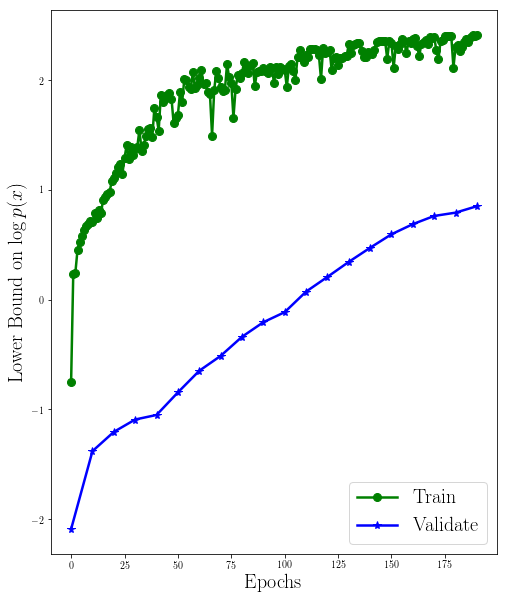

In [28]:
# evaluation
plt.figure(figsize=(8,10))
plt.plot(stats['train_bound'][:,0],-stats['train_bound'][:,1],'-o',color='g',label='Train')
plt.plot(stats['valid_bound'][:,0],-stats['valid_bound'][:,1],'-*',color='b',label='Validate')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Lower Bound on $\log p(x)$')

In [18]:
""" Reload the best DMM based on the validation error """

epochMin, valMin, idxMin = getLowestError(savedata['valid_bound'])
reloadFile= pfile.replace('-config.pkl','')+'-EP'+str(int(epochMin))+'-params.npz'

print 'Loading from : ',reloadFile
params['validate_only']          = True
dmm_best                         = DMM(params, paramFile = pfile, reloadFile = reloadFile)

Loading from :  ./chkpt-ipython-sliding//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP190-params.npz
	<<Reloading Model>>
	<<Loading structure (./chkpt-ipython-sliding//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-config.pkl) and model (./chkpt-ipython-sliding//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP190-params.npz) / opt (./chkpt-ipython-sliding//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-1000-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP190-optParams.npz) weights>>
Adding/Modifying loaded parameters:  validate_only  to  True
	<<Nparameters: 34125>>


models/__init__.py:201: UserWarning: lr found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")
models/__init__.py:201: UserWarning: anneal found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")
models/__init__.py:201: UserWarning: update_ctr found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")


	<<Anneal = 1 in 2.0 param. updates>>
	<<Building with RNN dropout:0.0>>
	<<In _LSTM_RNN_layer with dropout 0.0000>>
	<<Completed DMM setup>>
	<<_buildModel took : 24.6694 seconds>>


In [ ]:
# reloadFile = pfile.replace('-config.pkl','')+'-EP30'+'-params.npz'
# params['validate_only']          = True
# dmm_best                         = DMM(params, paramFile = pfile, reloadFile = reloadFile)

In [19]:
test_bound = DMM_evaluate.evaluateBound(dmm_best, dataset['test'], batch_size = params['batch_size'])
print("Test bound", test_bound)
print("Validation bound", stats['valid_bound'][-1,1])
print("Train bound", stats['train_bound'][-1,1])

	<<Original dim: [3 5 1],[3 5]>>
	<<New dim: [1989   10    1],[1989   10]>>
	<<(Evaluate) Validation Bound: -0.8228 [Took 0.2470 seconds]>>
('Test bound', -0.8227866970637454)
('Validation bound', -0.8508690744618493)
('Train bound', -2.4124076529853813)


In [20]:
train_pred, _ =DMM_evaluate.reconstruct(dmm_best, dataset['train'])

In [21]:
valid_pred, _ =DMM_evaluate.reconstruct(dmm_best, dataset['valid'])

In [22]:
test_pred, _ = DMM_evaluate.reconstruct(dmm_best, dataset['test'])

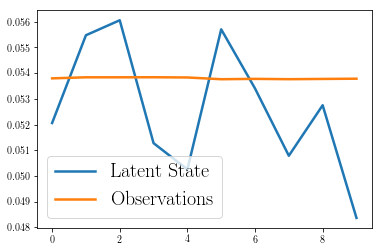

In [23]:
plt.plot(range(10), np.array(train_pred)[0, :, 0], label='Latent State')
plt.plot(range(10), train_all[train_idx[0]:train_idx[0]+10], label='Observations')
plt.legend(loc='best')

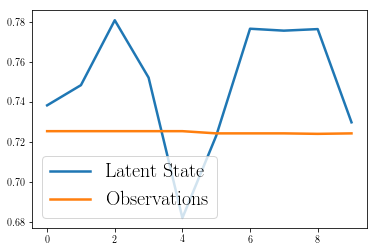

In [24]:
plt.plot(range(10), np.array(valid_pred)[0, :, :], label='Latent State')
plt.plot(range(10), train_all[valid_idx[0]:valid_idx[0]+10], label='Observations')
plt.legend(loc='best')

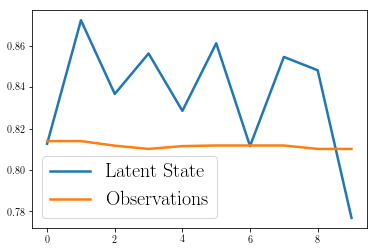

In [25]:
plt.plot(range(10), np.array(test_pred)[0, :, :], label='Latent State')
plt.plot(range(10), test_all[test_idx[0]:test_idx[0]+10], label='Observations')
plt.legend(loc='best')

In [26]:
def evaluate_rmse(prediction, dataset, idx):
    error_sum = 0
    for i in range(len(prediction)):
        error_sum += (dataset[idx[i]+10][0]-prediction[i][-1][0])**2
    error_sum /= (i+1)
    return np.sqrt(error_sum)

In [27]:
print("Training RMSE:", evaluate_rmse(train_pred, train_all, train_idx))
print("Validation RMSE:", evaluate_rmse(valid_pred, train_all, valid_idx))
print("Test RMSE:", evaluate_rmse(test_pred, test_all, test_idx))

('Training RMSE:', 0.022853932441741096)
('Validation RMSE:', 0.04157638925911327)
('Test RMSE:', 0.04092500504192664)
